In [1]:
import os
import random
import glob
from pathlib import Path
from network_swinir import SwinIR

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, LinearLR, SequentialLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm
from torchvision.utils import save_image

/opt/anaconda3/envs/dl/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
data_train = "data/train"
data_test = "data/test"
seed = 42

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Используется:", device)


### воспроизводимость
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(seed=seed)

Используется: mps


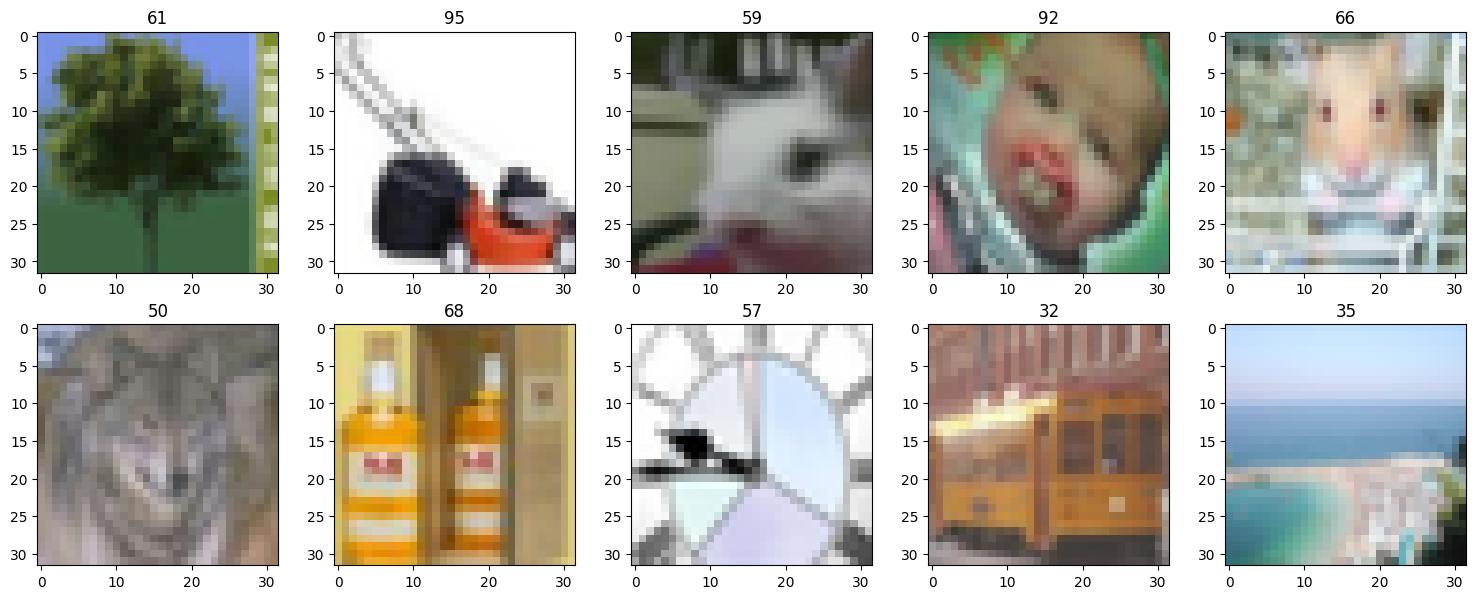

In [3]:
classes = os.listdir(data_train)[:10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, class_name in enumerate(classes):
    class_dir = os.path.join(data_train, class_name)

    img_name = os.listdir(class_dir)[0]

    img_path = os.path.join(class_dir, img_name)

    img = cv2.imread(img_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[i]

    ax.imshow(img_rgb)

    ax.set_title(class_name)

plt.tight_layout()

Изображения из-за своего маленького размера очень размытые, даже самому понять  сложно, что это вообще такое. Посмотрим на тестовый набор, что там есть, возможно, поймем какие аугментации нам нужны.

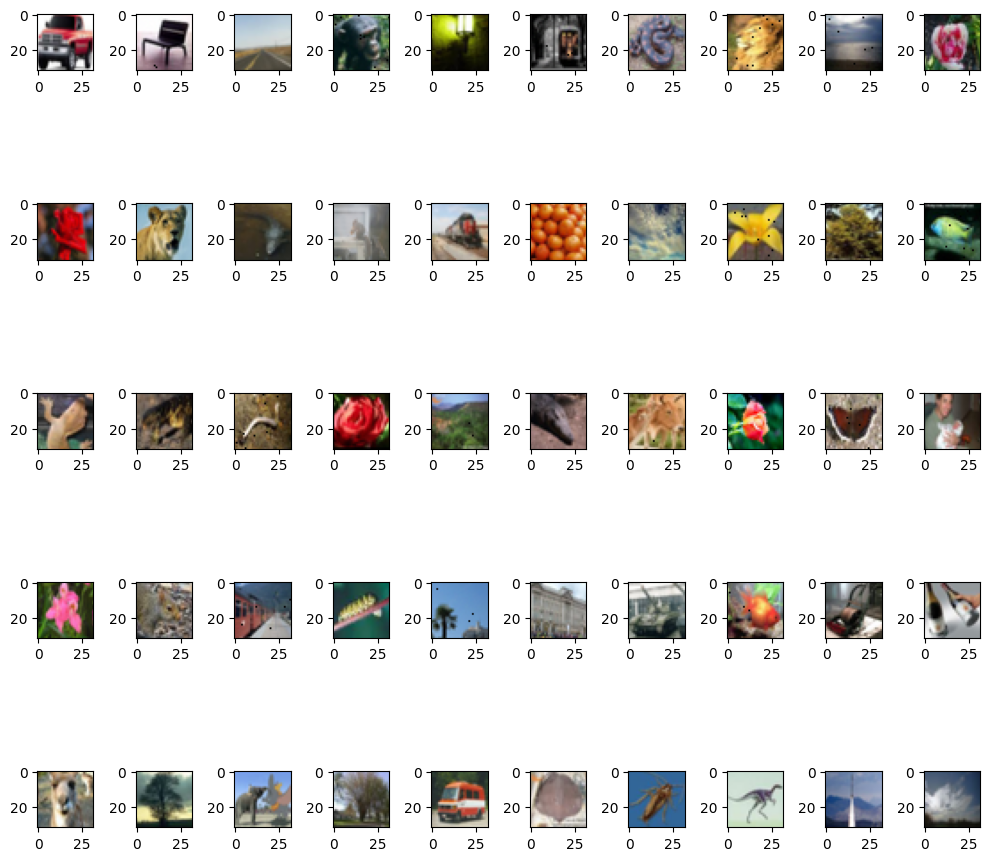

In [4]:
all_files = [
    f for f in os.listdir(data_test) if os.path.isfile(os.path.join(data_test, f))
]

pictures_names = all_files[:50]

fig, axes = plt.subplots(5, 10, figsize=(10, 10))
axes = axes.flatten()


for i, img_name in enumerate(pictures_names):

    img_path = os.path.join(data_test, img_name)

    img = cv2.imread(img_path)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax = axes[i]

    ax.imshow(img_rgb)


plt.tight_layout()


plt.show()

Из того, что я вижу нужно сделать аугментацию для дырявых изображений, остальные возможные аугментации не наблюдаю. Посмотрим на баланс классов

In [5]:
total_items = 0
num_classes = 0
counts_per_class = []

for class_name in os.listdir(data_train):
    if class_name != ".DS_Store":
        class_dir = os.path.join(data_train, class_name)
        count = len(os.listdir(class_dir))
        total_items += count
        num_classes += 1
        counts_per_class.append(count)


average_items_per_class = total_items / num_classes

print("Среднее количество элементов в классе:", average_items_per_class)
print("Стандартное отклонение количества элементов в классе:", np.std(counts_per_class))

Среднее количество элементов в классе: 95.1
Стандартное отклонение количества элементов в классе: 35.261452040436446


Довольно маленький датасет, с серьезным дисбалансом классов, этот момент следует прорабоать

# Выводы

1. Необходимо будет поработать с изображениями - применить upscaling с помощью SwiIR [жмяк](https://github.com/JingyunLiang/SwinIR) 
2. Аугментация будет в осноном состоять из **CoarseDropout** пресета
3. Присутствует дисбаланс классов, можно будет попробовать использовать **WeightedRandomSampler** как здесь [жмяк](https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/2?u=ptrblck) или **class_weight** в **CrossEntropyLoss**
4. **fine-tuning** или же **transfer learning** на модели с множеством параметром нет смысла катить, большой шанс переобучения.
5. Так как у нас в осноном картинки природы - можно попробовать брать веса моделей, обученных на **imagenet**, и использовать их в качестве базовых для нашей модели.

In [6]:
### базовые аугментации
train_pipeline_base = A.Compose(
    [
        A.HorizontalFlip(p=0.2),
        A.VerticalFlip(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


val_pipeline = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

In [7]:
### класс лоадер
class Loader(Dataset):
    def __init__(
        self,
        split="train",
        root_dir="data/train",
        transform=None,
    ):
        self.split = split
        self.transform = transform
        self.samples = []

        if split == "test":
            root_dir = "data/test"
            image_files = glob.glob(os.path.join(root_dir, "*.jpg")) + glob.glob(
                os.path.join(root_dir, "*.png")
            )

            def extract_number(path):
                name = os.path.splitext(os.path.basename(path))[0]
                try:
                    return int(name)
                except ValueError:
                    return float("inf")

            image_files = sorted(image_files, key=extract_number)

            for file_path in image_files:
                self.samples.append((file_path, 0))
        else:

            def split_files(files, split_type):
                n = len(files)
                sorted_files = sorted(files)
                if split_type == "train":
                    return sorted_files[: int(0.8 * n)]
                elif split_type == "val":
                    return sorted_files[int(0.8 * n) :]
                elif split_type == "train_itog":
                    return sorted_files
                return []

            for class_folder in sorted(os.listdir(root_dir)):
                class_path = os.path.join(root_dir, class_folder)
                if os.path.isdir(class_path):
                    try:
                        class_idx = int(class_folder)
                    except ValueError:
                        continue

                    image_files = glob.glob(os.path.join(class_path, "*"))
                    split_files_list = split_files(image_files, split)
                    for file_path in split_files_list:
                        self.samples.append((file_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)

        if image is None:
            next_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(next_idx)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            current_transform = self.transform

            augmented = current_transform(image=image)
            image = augmented["image"]

        return image, label


train_dataset = Loader(
    split="train",
    root_dir=data_train,
    transform=train_pipeline_base,
)
val_dataset = Loader(
    split="val",
    root_dir=data_train,
    transform=val_pipeline,
)

test_dataset = Loader(split="test", root_dir=data_test, transform=val_pipeline)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=100, in_channels=3):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=2, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.4)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=2, bias=False)
        self.bn6 = nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.dropout3(x)

        x = self.gap(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [9]:
simple_model_cnn = SimpleCNN()
simple_model_cnn.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (c

In [10]:
def train_one_epoch(model, criterion, optimizer, dataloader, device, epoch, num_epochs):
    model.train()

    running_loss = torch.tensor(0.0, device=device)
    correct_predictions = 0
    total_samples = 0

    batch_iterator = tqdm(
        dataloader, desc=f"Эпохи {epoch+1}/{num_epochs} обучения", leave=False
    )

    for inputs, labels in batch_iterator:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.contiguous()
        loss = criterion(outputs, labels)

        running_loss += loss.detach() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        current_acc = (
            (predicted == labels).sum().item() / labels.size(0)
            if labels.size(0) > 0
            else 0
        )
        batch_iterator.set_postfix(loss=f"{loss.item():.4f}", acc=f"{current_acc:.4f}")

    if total_samples > 0:
        epoch_loss = (running_loss / total_samples).item()
        epoch_accuracy = correct_predictions / total_samples
    else:
        epoch_loss = np.inf
        epoch_accuracy = 0

    return epoch_loss, epoch_accuracy


def validate(model, criterion, dataloader, device, epoch, num_epochs):
    model.eval()
    running_loss = torch.tensor(0.0, device=device)
    correct_predictions = 0
    total_samples = 0

    batch_iterator = tqdm(
        dataloader, desc=f"Эпохи {epoch+1}/{num_epochs} валидации", leave=False
    )

    with torch.no_grad():
        for inputs, labels in batch_iterator:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = outputs.contiguous()
            loss = criterion(outputs, labels)

            running_loss += loss.detach() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            current_acc = (predicted == labels).sum().item() / labels.size(0)
            batch_iterator.set_postfix(
                loss=f"{loss.item():.4f}", acc=f"{current_acc:.4f}"
            )

    if total_samples > 0:
        epoch_loss = (running_loss / total_samples).item()
        epoch_accuracy = correct_predictions / total_samples
    else:
        epoch_loss = np.inf
        epoch_accuracy = 0

    return epoch_loss, epoch_accuracy


def traning_loop(
    model,
    num_epochs,
    optimizer_initial,
    train_loader,
    val_loader,
    device,
    optimizer_switch=None,
    optimizer_switch_patience=None,
    criterion_initial=nn.CrossEntropyLoss(),
    criterion_switch=None,
    criterion_switch_patience=None,
    warmup_epochs=0,
    lr_scheduler_type="cosine",
    early_stop_patience=10,
    early_stop_metric="val_loss",
    best_model_path="models/best_model.pth",
    model_desc=None,
):

    if model_desc:
        os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
        base, ext = os.path.splitext(best_model_path)
        final_best_model_path = f"{base}_{model_desc}{ext}"
    else:
        final_best_model_path = best_model_path
        os.makedirs(os.path.dirname(final_best_model_path), exist_ok=True)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "lr": [],
    }
    best_metric_value = (
        float("inf") if early_stop_metric == "val_loss" else float("-inf")
    )

    es_epochs_no_improve = 0
    ls_epochs_no_improve = 0
    os_epochs_no_improve = 0

    best_epoch = -1
    scheduler = None
    switched_loss = False
    switched_optimizer = False
    dynamic_loss_switch_enabled = (
        criterion_switch is not None
        and criterion_switch_patience is not None
        and criterion_switch_patience > 0
    )
    dynamic_optimizer_switch_enabled = (
        optimizer_switch is not None
        and optimizer_switch_patience is not None
        and optimizer_switch_patience > 0
    )

    current_criterion = criterion_initial
    current_optimizer = optimizer_initial

    scheduler_warmup = None
    scheduler_main = None
    if warmup_epochs > 0 and warmup_epochs < num_epochs:
        scheduler_warmup = LinearLR(
            current_optimizer,
            start_factor=1e-4,
            end_factor=1.0,
            total_iters=warmup_epochs,
        )
        main_scheduler_start_epoch = warmup_epochs
    else:
        main_scheduler_start_epoch = 0

    main_scheduler_epochs = num_epochs - main_scheduler_start_epoch

    if main_scheduler_epochs > 0:
        if lr_scheduler_type == "cosine":
            scheduler_main = CosineAnnealingLR(
                current_optimizer, T_max=main_scheduler_epochs, eta_min=1e-6
            )
        elif lr_scheduler_type == "step":
            step_size = 10
            gamma = 0.1
            scheduler_main = StepLR(current_optimizer, step_size=step_size, gamma=gamma)

    if scheduler_warmup and scheduler_main:
        scheduler = SequentialLR(
            current_optimizer,
            schedulers=[scheduler_warmup, scheduler_main],
            milestones=[warmup_epochs],
        )
    elif scheduler_main:
        scheduler = scheduler_main
    elif scheduler_warmup:
        scheduler = scheduler_warmup

    outer_tqdm = tqdm(
        range(num_epochs),
        desc=f"Обучение модели ({model_desc if model_desc else 'NoDesc'})",
    )
    for epoch in outer_tqdm:

        train_loss, train_acc = train_one_epoch(
            model=model,
            criterion=current_criterion,
            optimizer=current_optimizer,
            dataloader=train_loader,
            device=device,
            epoch=epoch,
            num_epochs=num_epochs,
        )
        val_loss, val_acc = validate(
            model=model,
            criterion=current_criterion,
            dataloader=val_loader,
            device=device,
            epoch=epoch,
            num_epochs=num_epochs,
        )

        current_lr = current_optimizer.param_groups[0]["lr"]
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

        log_message = (
            f"Эпоха {epoch+1}/{num_epochs} | "
            f"Оптимайзер: {type(current_optimizer).__name__} | Loss: {type(current_criterion).__name__} | "
            f"Learning Rate: {current_lr:.2e} | Loss(Tr/Val): {train_loss:.3f}/{val_loss:.3f} | "
            f"Acc(Tr/Val): {train_acc:.3f}/{val_acc:.3f} | "
        )

        current_metric = val_loss if early_stop_metric == "val_loss" else val_acc
        is_better = (
            early_stop_metric == "val_loss" and current_metric < best_metric_value
        ) or (early_stop_metric == "val_acc" and current_metric > best_metric_value)

        if is_better:
            best_metric_value = current_metric
            log_message += f"(Лучшая метрика: {best_metric_value:.4f} @ Ep {epoch + 1}) | сохранение модели..."
            outer_tqdm.write(log_message)
            torch.save(model.state_dict(), final_best_model_path)
            es_epochs_no_improve = 0
            ls_epochs_no_improve = 0
            os_epochs_no_improve = 0
            best_epoch = epoch + 1
        else:
            es_epochs_no_improve += 1
            ls_epochs_no_improve += 1
            os_epochs_no_improve += 1
            stagnation_msg = f"Нет улучшений {es_epochs_no_improve} эпох."
            stagnation_msg += f"(Best: {best_metric_value:.4f})"
            if dynamic_loss_switch_enabled:
                stagnation_msg += f"[Loss swich подсчет: {ls_epochs_no_improve}/{criterion_switch_patience}]"
            if dynamic_optimizer_switch_enabled:
                stagnation_msg += f"[Optimizer подсчет: {os_epochs_no_improve}/{optimizer_switch_patience}]"
            stagnation_msg += (
                f"[Early stopping посчет: {es_epochs_no_improve}/{early_stop_patience}]"
            )
            outer_tqdm.write(log_message + stagnation_msg)

        if (
            dynamic_loss_switch_enabled
            and ls_epochs_no_improve >= criterion_switch_patience
            and not switched_loss
        ):
            current_criterion = criterion_switch
            switched_loss = True
            os_epochs_no_improve = 0
            outer_tqdm.write(
                f"Переключение Loss на {type(current_criterion).__name__}. Сброс стагнации для Early Stopping."
            )

        if (
            dynamic_optimizer_switch_enabled
            and os_epochs_no_improve >= optimizer_switch_patience
            and not switched_optimizer
        ):
            current_optimizer = optimizer_switch
            switched_optimizer = True
            new_optimizer_lr = current_optimizer.param_groups[0]["lr"]
            outer_tqdm.write(
                f"Переключение оптимайзер {type(current_optimizer).__name__} (Текущщий LR: {new_optimizer_lr:.2e})."
            )

            scheduler = None
            scheduler_main = None
            recreate_current_epoch = epoch + 1
            recreate_main_scheduler_start_epoch = recreate_current_epoch
            recreate_main_scheduler_epochs = max(
                0, num_epochs - recreate_main_scheduler_start_epoch
            )

            if recreate_main_scheduler_epochs > 0:
                if lr_scheduler_type == "cosine":
                    scheduler_main = CosineAnnealingLR(
                        current_optimizer,
                        T_max=recreate_main_scheduler_epochs,
                        eta_min=1e-6,
                    )
                elif lr_scheduler_type == "step":
                    step_size = 10
                    gamma = 0.1
                    scheduler_main = StepLR(
                        current_optimizer, step_size=step_size, gamma=gamma
                    )
            else:
                outer_tqdm.write(f"Не осталось эпох для создания нового шедулера.")

            scheduler = scheduler_main
            outer_tqdm.write(
                f"Шедулер пересоздан: {type(scheduler).__name__ if scheduler else 'None'}"
            )
            es_epochs_no_improve = 0

        if scheduler and not (
            switched_optimizer and os_epochs_no_improve == optimizer_switch_patience
        ):
            scheduler.step()

        if es_epochs_no_improve >= early_stop_patience:
            outer_tqdm.write(
                f"\nEarly stopping тригернулся после эпохи {epoch + 1}. Нет улучшений в '{early_stop_metric}' для {early_stop_patience} эпох."
            )
            outer_tqdm.write(
                f"Лучшая эпоха: {best_epoch}, лучшая метрика {early_stop_metric}: {best_metric_value:.4f}"
            )
            break

    num_epochs_completed = len(history["train_loss"])
    epochs_range = range(1, num_epochs_completed + 1)

    if num_epochs_completed > 0:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        ax1.plot(epochs_range, history["train_loss"], "bo-", label="Training Loss")
        ax1.plot(epochs_range, history["val_loss"], "ro-", label="Validation Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)

        ax2.plot(epochs_range, history["train_acc"], "bo-", label="Training Accuracy")
        ax2.plot(epochs_range, history["val_acc"], "ro-", label="Validation Accuracy")
        ax2.set_title("Training and Validation Accuracy")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        ax2.grid(True)

        if best_epoch != -1:
            ax1.axvline(
                x=best_epoch,
                color="grey",
                linestyle="--",
                label=f"Лучшая эпоха ({best_epoch})",
            )
            ax2.axvline(
                x=best_epoch,
                color="grey",
                linestyle="--",
                label=f"Лучшая эпоха ({best_epoch})",
            )
            ax1.legend()
            ax2.legend()

        plt.tight_layout()
        plt.show()

    if best_epoch != -1 and os.path.exists(final_best_model_path):
        print(
            f"Загрузка весов лучшей модели {best_epoch} сохранённой в {final_best_model_path}"
        )
        model.load_state_dict(
            torch.load(final_best_model_path, map_location=device, weights_only=True)
        )
    else:
        print(
            f"Нет улучшений в модели или нет файла в  {final_best_model_path}. Возвращаемся к модели к последней эпохе ({num_epochs_completed})."
        )

    return model

Обучение модели (cnn_simple_model_base_aug):   0%|          | 0/30 [00:00<?, ?it/s]

Эпохи 1/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 1.00e-06 | Loss(Tr/Val): 4.629/4.615 | Acc(Tr/Val): 0.012/0.015 | (Лучшая метрика: 0.0150 @ Ep 1) | сохранение модели...


Эпохи 2/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 2/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 2.00e-03 | Loss(Tr/Val): 4.446/4.311 | Acc(Tr/Val): 0.041/0.068 | (Лучшая метрика: 0.0676 @ Ep 2) | сохранение модели...


Эпохи 3/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 3/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 4.00e-03 | Loss(Tr/Val): 4.178/4.076 | Acc(Tr/Val): 0.078/0.078 | (Лучшая метрика: 0.0784 @ Ep 3) | сохранение модели...


Эпохи 4/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 4/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 6.00e-03 | Loss(Tr/Val): 3.979/3.893 | Acc(Tr/Val): 0.099/0.098 | (Лучшая метрика: 0.0975 @ Ep 4) | сохранение модели...


Эпохи 5/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 5/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 8.00e-03 | Loss(Tr/Val): 3.845/3.871 | Acc(Tr/Val): 0.107/0.109 | (Лучшая метрика: 0.1094 @ Ep 5) | сохранение модели...


/opt/anaconda3/envs/dl/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Эпохи 6/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 6/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 6/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 1.00e-02 | Loss(Tr/Val): 3.730/3.796 | Acc(Tr/Val): 0.120/0.118 | (Лучшая метрика: 0.1182 @ Ep 6) | сохранение модели...


Эпохи 7/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 7/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 7/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 9.96e-03 | Loss(Tr/Val): 3.604/3.607 | Acc(Tr/Val): 0.150/0.143 | (Лучшая метрика: 0.1434 @ Ep 7) | сохранение модели...


Эпохи 8/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 8/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 8/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 9.84e-03 | Loss(Tr/Val): 3.481/3.517 | Acc(Tr/Val): 0.163/0.169 | (Лучшая метрика: 0.1687 @ Ep 8) | сохранение модели...


Эпохи 9/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 9/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 9/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 9.65e-03 | Loss(Tr/Val): 3.374/3.513 | Acc(Tr/Val): 0.186/0.173 | (Лучшая метрика: 0.1734 @ Ep 9) | сохранение модели...


Эпохи 10/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 10/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 10/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 9.38e-03 | Loss(Tr/Val): 3.276/3.375 | Acc(Tr/Val): 0.204/0.185 | (Лучшая метрика: 0.1847 @ Ep 10) | сохранение модели...


Эпохи 11/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 11/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 11/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 9.05e-03 | Loss(Tr/Val): 3.161/3.334 | Acc(Tr/Val): 0.232/0.203 | (Лучшая метрика: 0.2028 @ Ep 11) | сохранение модели...


Эпохи 12/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 12/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 12/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 8.64e-03 | Loss(Tr/Val): 3.077/3.214 | Acc(Tr/Val): 0.246/0.217 | (Лучшая метрика: 0.2172 @ Ep 12) | сохранение модели...


Эпохи 13/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 13/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 13/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 8.19e-03 | Loss(Tr/Val): 2.985/3.111 | Acc(Tr/Val): 0.258/0.235 | (Лучшая метрика: 0.2348 @ Ep 13) | сохранение модели...


Эпохи 14/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 14/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 14/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 7.68e-03 | Loss(Tr/Val): 2.897/3.105 | Acc(Tr/Val): 0.275/0.230 | Нет улучшений 1 эпох.(Best: 0.2348)[Optimizer подсчет: 1/3][Early stopping посчет: 1/10]


Эпохи 15/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 15/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 15/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 7.13e-03 | Loss(Tr/Val): 2.825/3.060 | Acc(Tr/Val): 0.291/0.241 | (Лучшая метрика: 0.2410 @ Ep 15) | сохранение модели...


Эпохи 16/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 16/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 16/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 6.55e-03 | Loss(Tr/Val): 2.754/3.019 | Acc(Tr/Val): 0.311/0.251 | (Лучшая метрика: 0.2508 @ Ep 16) | сохранение модели...


Эпохи 17/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 17/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 17/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 5.94e-03 | Loss(Tr/Val): 2.674/2.902 | Acc(Tr/Val): 0.322/0.277 | (Лучшая метрика: 0.2766 @ Ep 17) | сохранение модели...


Эпохи 18/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 18/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 18/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 5.31e-03 | Loss(Tr/Val): 2.610/2.858 | Acc(Tr/Val): 0.338/0.283 | (Лучшая метрика: 0.2833 @ Ep 18) | сохранение модели...


Эпохи 19/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 19/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 19/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 4.69e-03 | Loss(Tr/Val): 2.554/2.767 | Acc(Tr/Val): 0.343/0.309 | (Лучшая метрика: 0.3091 @ Ep 19) | сохранение модели...


Эпохи 20/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 20/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 20/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 4.06e-03 | Loss(Tr/Val): 2.482/2.767 | Acc(Tr/Val): 0.360/0.295 | Нет улучшений 1 эпох.(Best: 0.3091)[Optimizer подсчет: 1/3][Early stopping посчет: 1/10]


Эпохи 21/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 21/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 21/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 3.46e-03 | Loss(Tr/Val): 2.430/2.709 | Acc(Tr/Val): 0.375/0.304 | Нет улучшений 2 эпох.(Best: 0.3091)[Optimizer подсчет: 2/3][Early stopping посчет: 2/10]


Эпохи 22/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 22/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 22/30 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 2.87e-03 | Loss(Tr/Val): 2.365/2.720 | Acc(Tr/Val): 0.388/0.308 | Нет улучшений 3 эпох.(Best: 0.3091)[Optimizer подсчет: 3/3][Early stopping посчет: 3/10]
Переключение оптимайзер AdamW (Текущщий LR: 1.00e-03).
Шедулер пересоздан: CosineAnnealingLR


Эпохи 23/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 23/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 23/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-03 | Loss(Tr/Val): 2.884/2.934 | Acc(Tr/Val): 0.270/0.273 | Нет улучшений 1 эпох.(Best: 0.3091)[Optimizer подсчет: 4/3][Early stopping посчет: 1/10]


Эпохи 24/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 24/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 24/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.62e-04 | Loss(Tr/Val): 2.681/2.753 | Acc(Tr/Val): 0.316/0.303 | Нет улучшений 2 эпох.(Best: 0.3091)[Optimizer подсчет: 5/3][Early stopping посчет: 2/10]


Эпохи 25/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 25/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 25/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 8.54e-04 | Loss(Tr/Val): 2.526/2.752 | Acc(Tr/Val): 0.350/0.293 | Нет улучшений 3 эпох.(Best: 0.3091)[Optimizer подсчет: 6/3][Early stopping посчет: 3/10]


Эпохи 26/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 26/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 26/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.92e-04 | Loss(Tr/Val): 2.381/2.614 | Acc(Tr/Val): 0.378/0.332 | (Лучшая метрика: 0.3318 @ Ep 26) | сохранение модели...


Эпохи 27/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 27/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 27/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 5.01e-04 | Loss(Tr/Val): 2.247/2.582 | Acc(Tr/Val): 0.404/0.344 | (Лучшая метрика: 0.3437 @ Ep 27) | сохранение модели...


Эпохи 28/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 28/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 28/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.09e-04 | Loss(Tr/Val): 2.117/2.477 | Acc(Tr/Val): 0.445/0.367 | (Лучшая метрика: 0.3669 @ Ep 28) | сохранение модели...


Эпохи 29/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 29/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 29/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.47e-04 | Loss(Tr/Val): 1.984/2.409 | Acc(Tr/Val): 0.473/0.374 | (Лучшая метрика: 0.3741 @ Ep 29) | сохранение модели...


Эпохи 30/30 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 30/30 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 30/30 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.90e-05 | Loss(Tr/Val): 1.907/2.376 | Acc(Tr/Val): 0.500/0.378 | (Лучшая метрика: 0.3777 @ Ep 30) | сохранение модели...


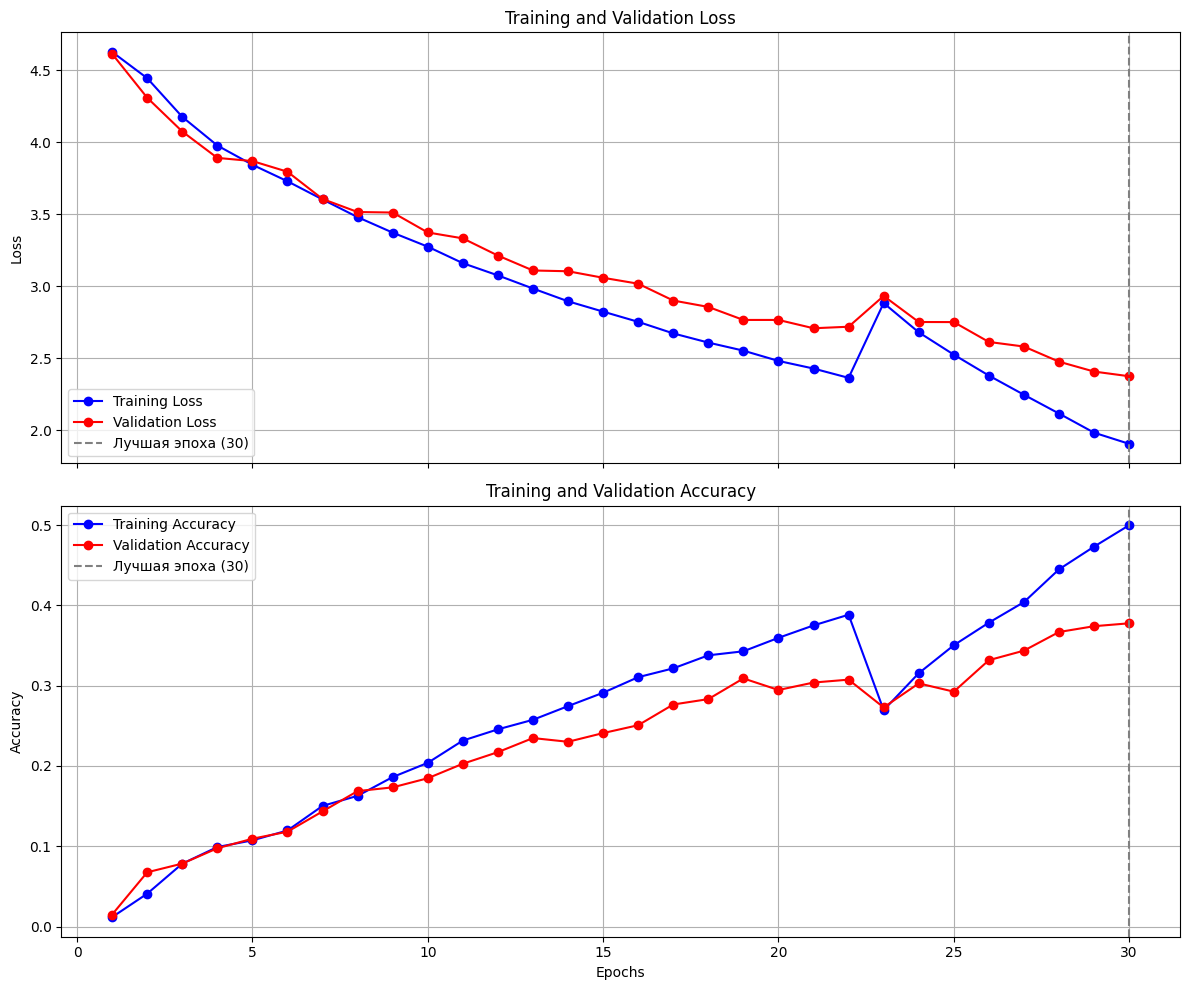

Загрузка весов лучшей модели 30 сохранённой в models/best_model_cnn_simple_model_base_aug.pth


In [11]:
simple_model_cnn = traning_loop(
    model=simple_model_cnn,
    optimizer_initial=optim.SGD(simple_model_cnn.parameters(), lr=0.01, momentum=0.9),
    optimizer_switch=optim.AdamW(simple_model_cnn.parameters(), lr=0.001),
    optimizer_switch_patience=3,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=5,
    model_desc="cnn_simple_model_base_aug",
    num_epochs=30,
    early_stop_metric="val_acc",
    early_stop_patience=10,
)

# Сложные аугментации

In [12]:
train_transform = A.Compose(
    [
        A.Resize(height=224, width=224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.2),
        A.RandomGridShuffle(p=0.3),
        A.HorizontalFlip(p=0.2),
        A.RandomRotate90(p=0.2),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 1), lightness=(0.5, 1.5), p=0.7),
        A.Normalize(),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.Resize(224, 224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)

In [13]:
train_dataset = Loader(
    root_dir="data/train",
    split="train",
    transform=train_transform,
)
val_dataset = Loader(root_dir="data/train", split="val", transform=val_transform)

In [14]:
def get_sampler(target):
    target = np.array(target)
    unique_classes, class_sample_count = np.unique(target, return_counts=True)
    weight = 1.0 / class_sample_count
    class_weights_dict = {cls: w for cls, w in zip(unique_classes, weight)}
    samples_weight = np.array([class_weights_dict[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weight = samples_weight.float()
    sampler = torch.utils.data.WeightedRandomSampler(
        samples_weight, len(samples_weight)
    )
    return sampler


train_targets = [label for _, label in train_dataset.samples]

train_sampler = get_sampler(train_targets) if train_targets else None

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [19]:
test_dataset = Loader(root_dir="data/test", split="test", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# EfficientNetB0

In [20]:
model_EfficientNetB0 = torchvision.models.efficientnet_b0(
    weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
)

In [21]:
model_EfficientNetB0.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [22]:
for param in model_EfficientNetB0.parameters():
    param.requires_grad = False

num_features = model_EfficientNetB0.classifier[1].in_features
num_classes = 100

head = nn.Sequential(
    nn.Linear(num_features, 640),
    nn.ReLU(),
    nn.Linear(640, 320),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(320, num_classes),
)

model_EfficientNetB0.classifier = head

model_EfficientNetB0.to("mps")

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Обучение модели (efficientnet-b0_head):   0%|          | 0/5 [00:00<?, ?it/s]

Эпохи 1/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-03 | Loss(Tr/Val): 3.994/3.031 | Acc(Tr/Val): 0.099/0.223 | (Лучшая метрика: 0.2234 @ Ep 1) | сохранение модели...


Эпохи 2/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 2/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.05e-04 | Loss(Tr/Val): 2.966/2.418 | Acc(Tr/Val): 0.254/0.360 | (Лучшая метрика: 0.3602 @ Ep 2) | сохранение модели...


Эпохи 3/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 3/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.55e-04 | Loss(Tr/Val): 2.673/2.153 | Acc(Tr/Val): 0.306/0.416 | (Лучшая метрика: 0.4164 @ Ep 3) | сохранение модели...


Эпохи 4/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 4/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.46e-04 | Loss(Tr/Val): 2.484/2.016 | Acc(Tr/Val): 0.356/0.463 | (Лучшая метрика: 0.4628 @ Ep 4) | сохранение модели...


Эпохи 5/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 5/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.64e-05 | Loss(Tr/Val): 2.399/1.975 | Acc(Tr/Val): 0.377/0.466 | (Лучшая метрика: 0.4659 @ Ep 5) | сохранение модели...


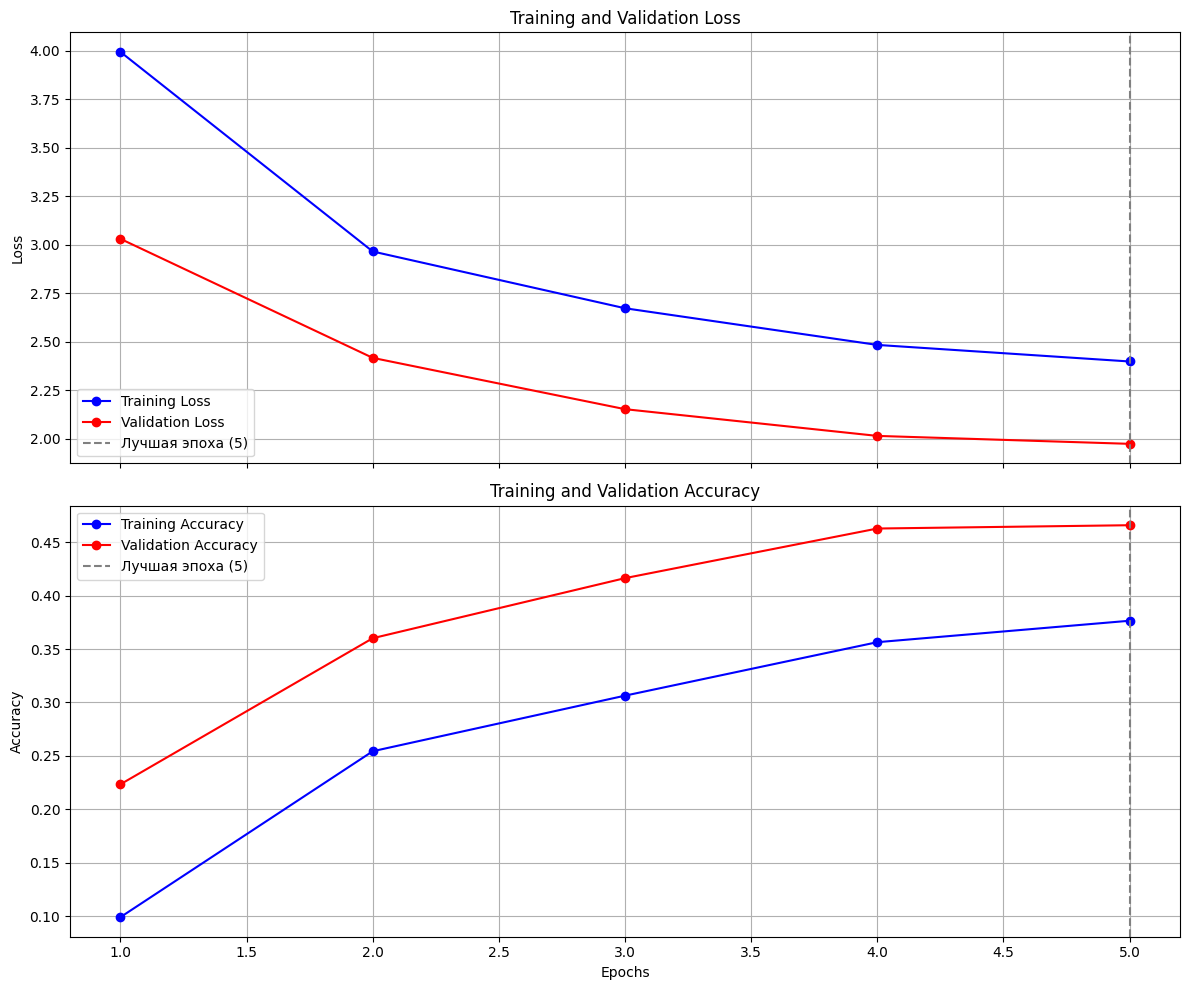

Загрузка весов лучшей модели 5 сохранённой в models/best_model_efficientnet-b0_head.pth


In [23]:
model_EfficientNetB0 = traning_loop(
    model=model_EfficientNetB0,
    optimizer_initial=optim.AdamW(
        model_EfficientNetB0.parameters(), lr=0.001, weight_decay=1e-4
    ),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=5,
    model_desc="efficientnet-b0_head",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=5,
)

## Предскажем 

In [24]:
my_submit = pd.read_csv("sample_submission.csv")
my_submit.head()


def predict_on_test(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_loader:
            if isinstance(images, (list, tuple)):
                images = images[0]

            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

In [25]:
my_submit.to_csv("efficientnet-b0_head.csv", index=False)

## Fine-tuning

Обучение модели (efficientnet-b0_fine-tuning):   0%|          | 0/5 [00:00<?, ?it/s]

Эпохи 1/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-04 | Loss(Tr/Val): 2.017/1.482 | Acc(Tr/Val): 0.464/0.577 | (Лучшая метрика: 0.5769 @ Ep 1) | сохранение модели...


Эпохи 2/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 2/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.05e-05 | Loss(Tr/Val): 1.623/1.290 | Acc(Tr/Val): 0.541/0.619 | (Лучшая метрика: 0.6187 @ Ep 2) | сохранение модели...


Эпохи 3/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 3/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.58e-05 | Loss(Tr/Val): 1.464/1.221 | Acc(Tr/Val): 0.582/0.639 | (Лучшая метрика: 0.6388 @ Ep 3) | сохранение модели...


Эпохи 4/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 4/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.52e-05 | Loss(Tr/Val): 1.346/1.149 | Acc(Tr/Val): 0.615/0.655 | (Лучшая метрика: 0.6553 @ Ep 4) | сохранение модели...


Эпохи 5/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 5/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.05e-05 | Loss(Tr/Val): 1.270/1.141 | Acc(Tr/Val): 0.637/0.648 | Нет улучшений 1 эпох.(Best: 0.6553)[Early stopping посчет: 1/4]


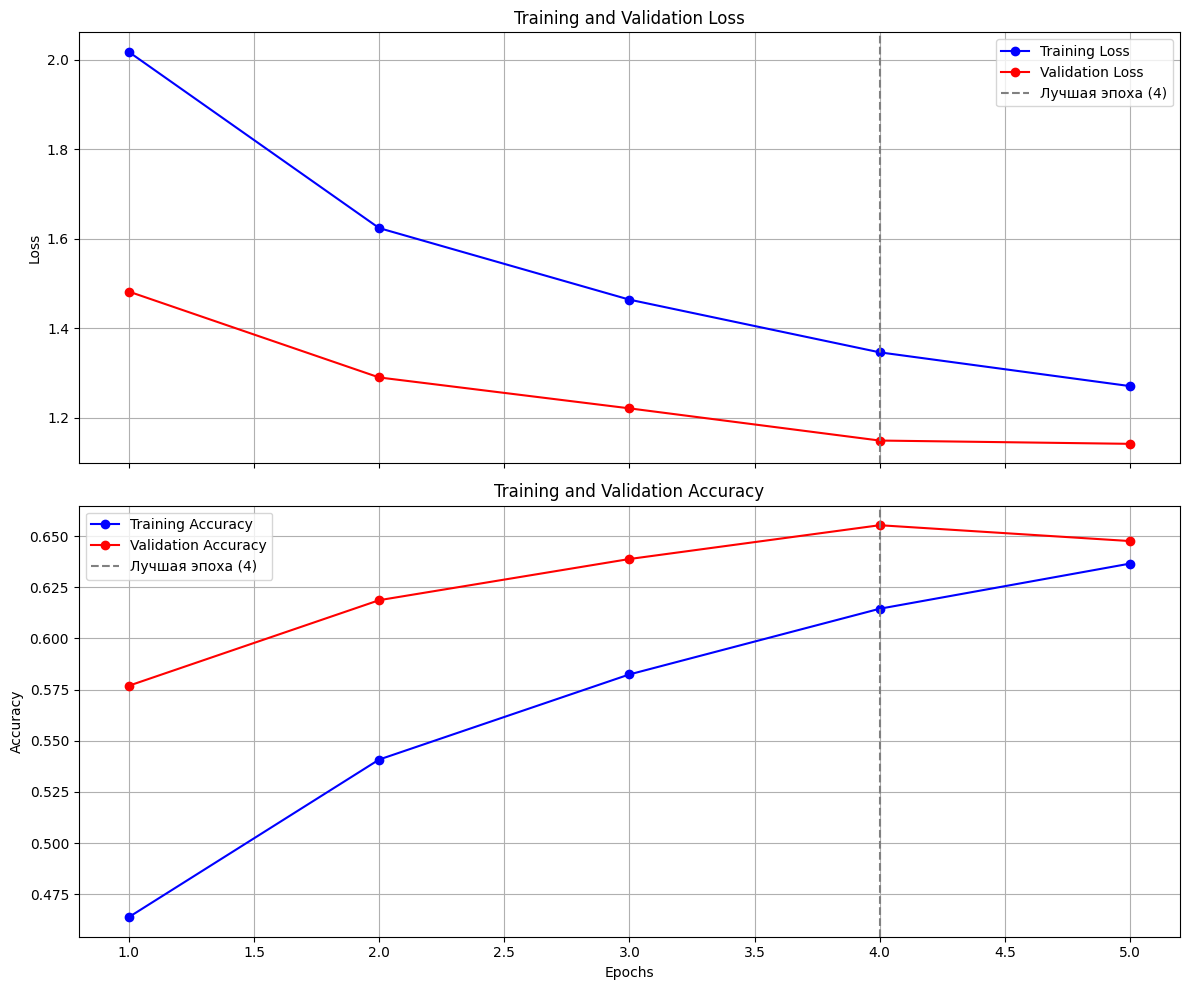

Загрузка весов лучшей модели 4 сохранённой в models/best_model_efficientnet-b0_fine-tuning.pth


In [ ]:
for param in model_EfficientNetB0.parameters():
    param.requires_grad = True

optimizer_ft = torch.optim.AdamW(
    model_EfficientNetB0.parameters(), lr=0.0001, weight_decay=1e-4
)


model_EfficientNetB0 = traning_loop(
    model=model_EfficientNetB0,
    optimizer_initial=optimizer_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=0,
    model_desc="efficientnet-b0_fine-tuning",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=4,
)

In [27]:
my_submit["target"] = predict_on_test(model_EfficientNetB0, test_loader, device)
my_submit.to_csv("efficientnet-b0_fine-tuning.csv", index=False)

# ResNet18

In [28]:
model_ResNet18 = torchvision.models.resnet18(
    weights=torchvision.models.resnet.ResNet18_Weights.DEFAULT
)

In [29]:
model_ResNet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
for param in model_ResNet18.parameters():
    param.requires_grad = False

num_features = model_ResNet18.fc.in_features
num_classes = 100

head = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, num_classes),
)

model_ResNet18.fc = head

model_ResNet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Обучение модели (ResNet_head):   0%|          | 0/5 [00:00<?, ?it/s]

Эпохи 1/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-03 | Loss(Tr/Val): 4.419/3.837 | Acc(Tr/Val): 0.044/0.143 | (Лучшая метрика: 0.1434 @ Ep 1) | сохранение модели...


Эпохи 2/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 2/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.05e-04 | Loss(Tr/Val): 3.713/3.182 | Acc(Tr/Val): 0.115/0.219 | (Лучшая метрика: 0.2193 @ Ep 2) | сохранение модели...


Эпохи 3/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 3/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.55e-04 | Loss(Tr/Val): 3.356/2.902 | Acc(Tr/Val): 0.166/0.246 | (Лучшая метрика: 0.2461 @ Ep 3) | сохранение модели...


Эпохи 4/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 4/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.46e-04 | Loss(Tr/Val): 3.209/2.759 | Acc(Tr/Val): 0.192/0.299 | (Лучшая метрика: 0.2993 @ Ep 4) | сохранение модели...


Эпохи 5/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 5/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.64e-05 | Loss(Tr/Val): 3.107/2.661 | Acc(Tr/Val): 0.203/0.319 | (Лучшая метрика: 0.3194 @ Ep 5) | сохранение модели...


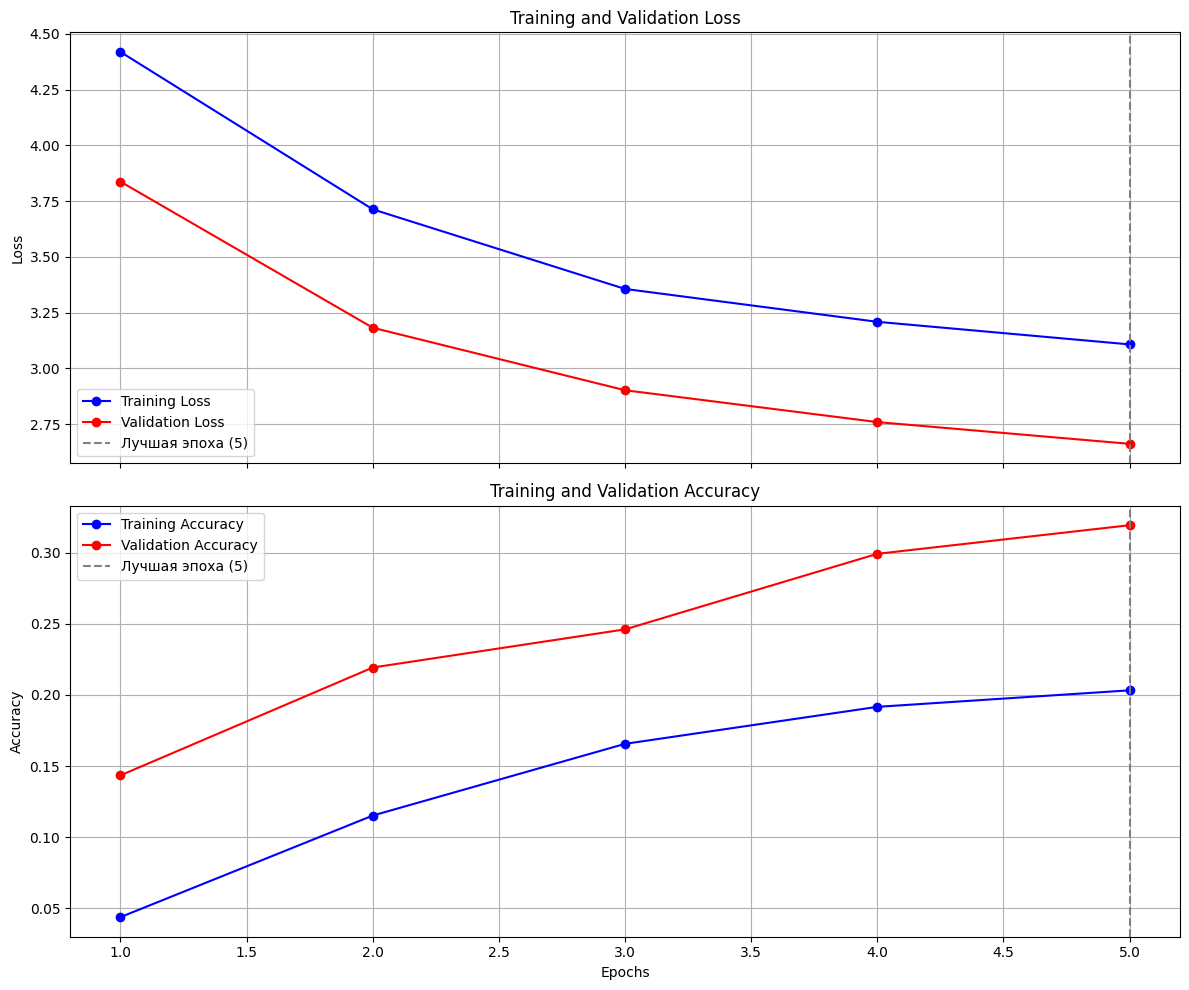

Загрузка весов лучшей модели 5 сохранённой в models/best_model_ResNet_head.pth


In [ ]:
model_ResNet18 = traning_loop(
    model=model_ResNet18,
    optimizer_initial=optim.AdamW(
        model_ResNet18.parameters(), lr=0.001, weight_decay=1e-4
    ),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=5,
    model_desc="ResNet18_head",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=5,
    lr_scheduler_type="cosine",
)

Обучение модели (ResNet_fine-tuning):   0%|          | 0/5 [00:00<?, ?it/s]

Эпохи 1/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-04 | Loss(Tr/Val): 2.687/2.048 | Acc(Tr/Val): 0.289/0.447 | (Лучшая метрика: 0.4469 @ Ep 1) | сохранение модели...


Эпохи 2/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 2/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.05e-05 | Loss(Tr/Val): 2.313/1.813 | Acc(Tr/Val): 0.363/0.496 | (Лучшая метрика: 0.4959 @ Ep 2) | сохранение модели...


Эпохи 3/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 3/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.58e-05 | Loss(Tr/Val): 2.068/1.653 | Acc(Tr/Val): 0.423/0.539 | (Лучшая метрика: 0.5387 @ Ep 3) | сохранение модели...


Эпохи 4/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 4/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.52e-05 | Loss(Tr/Val): 1.900/1.567 | Acc(Tr/Val): 0.465/0.569 | (Лучшая метрика: 0.5686 @ Ep 4) | сохранение модели...


Эпохи 5/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 5/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.05e-05 | Loss(Tr/Val): 1.856/1.527 | Acc(Tr/Val): 0.474/0.585 | (Лучшая метрика: 0.5846 @ Ep 5) | сохранение модели...


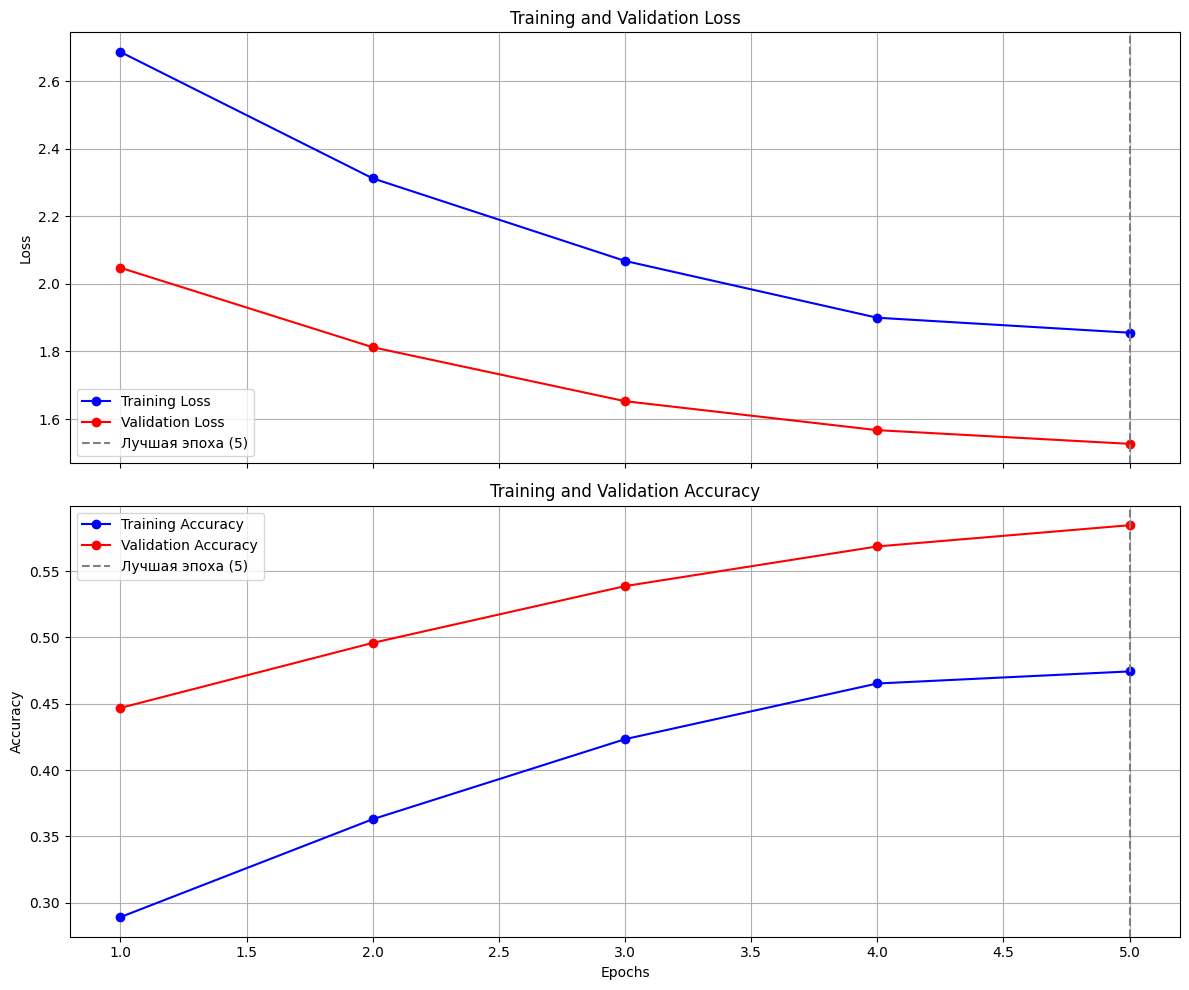

Загрузка весов лучшей модели 5 сохранённой в models/best_model_ResNet_fine-tuning.pth


In [ ]:
for param in model_ResNet18.parameters():
    param.requires_grad = True

optimizer_ft = torch.optim.AdamW(
    model_ResNet18.parameters(), lr=0.0001, weight_decay=1e-4
)


model_ResNet18 = traning_loop(
    model=model_ResNet18,
    optimizer_initial=optimizer_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=0,
    model_desc="ResNet18_fine-tuning",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=3,
)

In [36]:
my_submit["target"] = predict_on_test(model_ResNet18, test_loader, device)
my_submit.to_csv("ResNet_fine-tuning.csv", index=False)

# Densenet-161 (Лучая модель fine-tuning)

In [37]:
model_Densenet161 = torchvision.models.densenet161(
    weights=torchvision.models.DenseNet161_Weights.DEFAULT
)

In [38]:
model_Densenet161

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [39]:
for param in model_Densenet161.parameters():
    param.requires_grad = False

num_features = model_Densenet161.classifier.in_features
num_classes = 100

head = nn.Sequential(
    nn.Linear(num_features, 1104),
    nn.ReLU(),
    nn.Linear(1104, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),
)

model_Densenet161.classifier = head

model_Densenet161.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

Обучение модели (ResNet_head):   0%|          | 0/5 [00:00<?, ?it/s]

Эпохи 1/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-03 | Loss(Tr/Val): 4.450/3.755 | Acc(Tr/Val): 0.031/0.091 | (Лучшая метрика: 0.0908 @ Ep 1) | сохранение модели...


Эпохи 2/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 2/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.05e-04 | Loss(Tr/Val): 3.681/2.959 | Acc(Tr/Val): 0.104/0.228 | (Лучшая метрика: 0.2276 @ Ep 2) | сохранение модели...


Эпохи 3/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 3/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.55e-04 | Loss(Tr/Val): 3.211/2.480 | Acc(Tr/Val): 0.172/0.343 | (Лучшая метрика: 0.3426 @ Ep 3) | сохранение модели...


Эпохи 4/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 4/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.46e-04 | Loss(Tr/Val): 2.965/2.324 | Acc(Tr/Val): 0.220/0.356 | (Лучшая метрика: 0.3555 @ Ep 4) | сохранение модели...


Эпохи 5/5 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 5/5 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/5 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.64e-05 | Loss(Tr/Val): 2.850/2.253 | Acc(Tr/Val): 0.248/0.392 | (Лучшая метрика: 0.3916 @ Ep 5) | сохранение модели...


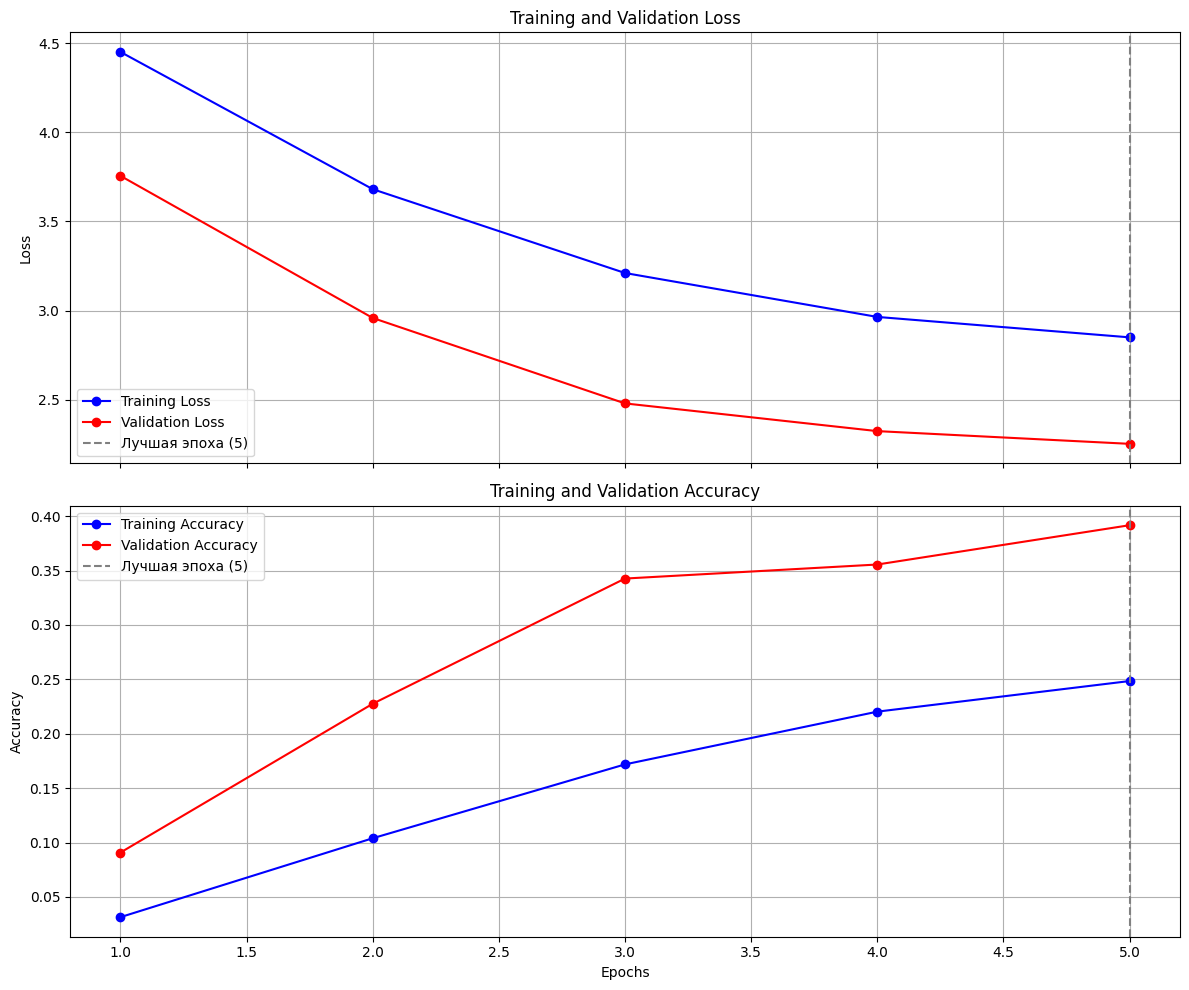

Загрузка весов лучшей модели 5 сохранённой в models/best_model_ResNet_head.pth


In [40]:
model_Densenet161 = traning_loop(
    model=model_Densenet161,
    optimizer_initial=optim.AdamW(
        model_Densenet161.parameters(), lr=0.001, weight_decay=1e-4
    ),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=5,
    model_desc="Densenet161_head",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=5,
    lr_scheduler_type="cosine",
)

In [41]:
# Лучшая модель, скор на тесте 0.74427

Обучение модели (Densenet161_fine-tuning):   0%|          | 0/1 [00:00<?, ?it/s]

Эпохи 1/1 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/1 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/1 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-04 | Loss(Tr/Val): 2.389/1.620 | Acc(Tr/Val): 0.339/0.555 | (Лучшая метрика: 0.5552 @ Ep 1) | сохранение модели...


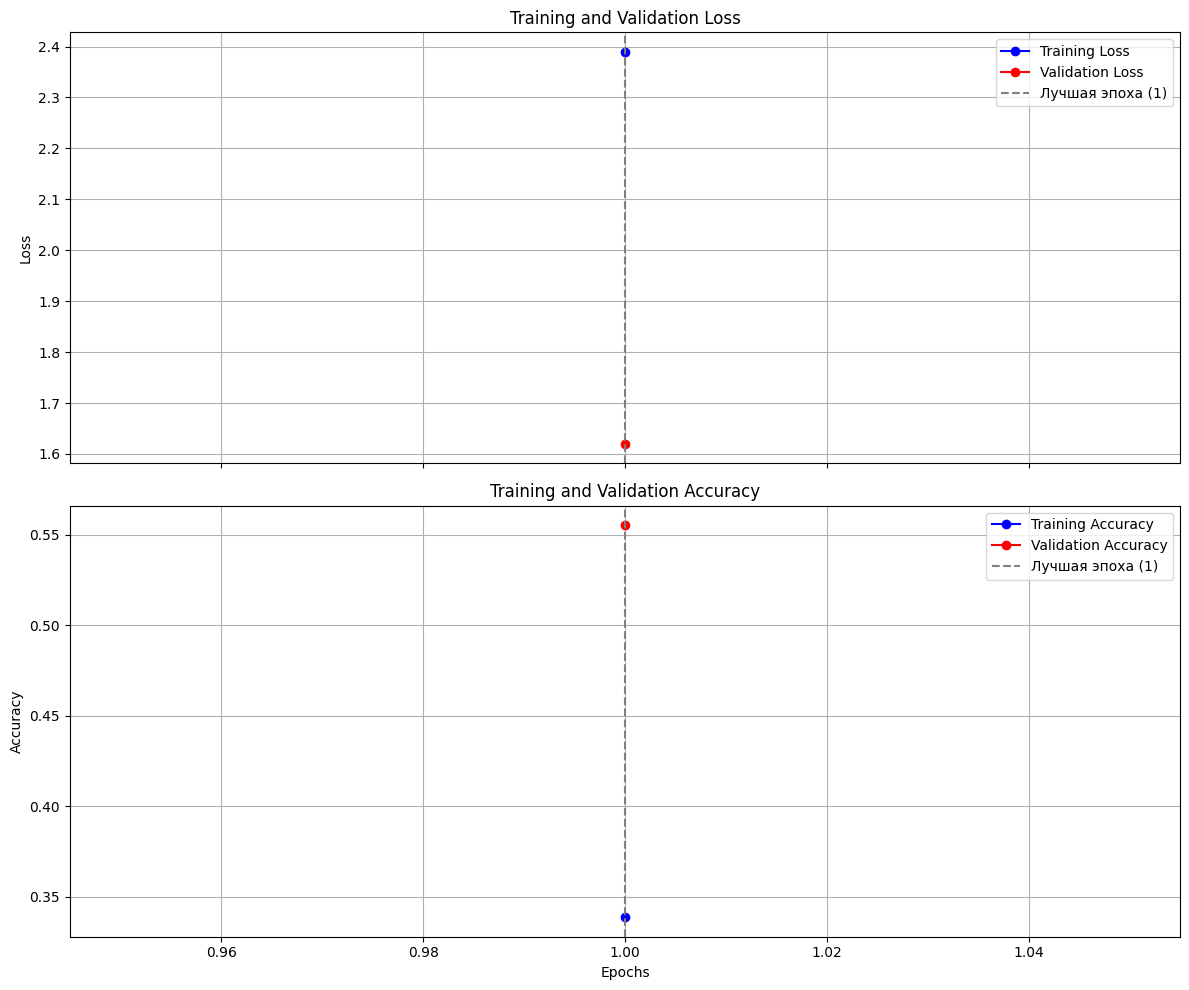

Загрузка весов лучшей модели 1 сохранённой в models/best_model_Densenet161_fine-tuning.pth


In [ ]:
for param in model_Densenet161.parameters():
    param.requires_grad = True

optimizer_ft = torch.optim.AdamW(
    model_Densenet161.parameters(), lr=0.0001, weight_decay=1e-4
)


model_Densenet161 = traning_loop(
    model=model_Densenet161,
    optimizer_initial=optimizer_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=3,
    model_desc="Densenet161_fine-tuning",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=3,
)

In [44]:
my_submit["target"] = predict_on_test(model_Densenet161, test_loader, device)
my_submit.to_csv("densenet161_fine-tuning.csv", index=False)

# Гипотеза с upscaling-ом

In [45]:
model_path = "upscale_models/classical_SR/001_classicalSR_DIV2K_s48w8_SwinIR-M_x2.pth"
input_root_dir = Path("data")
output_root_dir = Path("upscaled_data/64_64")
splits_to_process = ["train", "test"]
supported_extensions = [".png", ".jpg", ".jpeg"]


model = SwinIR(
    upscale=2,
    in_chans=3,
    img_size=48,
    window_size=8,
    img_range=1.0,
    depths=[6, 6, 6, 6, 6, 6],
    embed_dim=180,
    num_heads=[6, 6, 6, 6, 6, 6],
    mlp_ratio=2,
    upsampler="pixelshuffle",
    resi_connection="1conv",
)

loaded_state = torch.load(model_path, map_location=torch.device(device))
if "params_ema" in loaded_state:
    actual_state_dict = loaded_state["params_ema"]
elif "params" in loaded_state:
    actual_state_dict = loaded_state["params"]
else:
    actual_state_dict = loaded_state

model.load_state_dict(actual_state_dict, strict=True)
model.eval()
model.to(device)

all_image_paths = []
input_output_mapping = {}

for split in splits_to_process:
    input_base_dir = input_root_dir / split
    output_base_dir = output_root_dir / split
    output_base_dir.mkdir(parents=True, exist_ok=True)

    found_paths_in_split = []
    if input_base_dir.is_dir():
        for item in input_base_dir.rglob("*"):
            if item.is_file() and item.suffix.lower() in supported_extensions:
                found_paths_in_split.append(item)
                input_output_mapping[item] = (input_base_dir, output_base_dir)
    all_image_paths.extend(found_paths_in_split)

for input_path in tqdm(all_image_paths, desc="Upscaling"):
    input_base_dir_for_file, output_base_dir_for_file = input_output_mapping[input_path]

    relative_path = input_path.relative_to(input_base_dir_for_file)
    output_dir = output_base_dir_for_file / relative_path.parent
    output_path = output_dir / f"{input_path.stem}_upscaled{input_path.suffix}"
    output_dir.mkdir(parents=True, exist_ok=True)

    img_lr_bgr = cv2.imread(str(input_path))
    img_lr_rgb = cv2.cvtColor(img_lr_bgr, cv2.COLOR_BGR2RGB)
    img_lr_norm = img_lr_rgb.astype(np.float32) / 255.0
    img_lr_tensor = torch.from_numpy(np.transpose(img_lr_norm, (2, 0, 1))).float()
    img_lr_tensor = img_lr_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        mod_pad_h, mod_pad_w = 0, 0
        _, _, h, w = img_lr_tensor.size()
        window_size = model.window_size
        if h % window_size != 0:
            mod_pad_h = window_size - h % window_size
        if w % window_size != 0:
            mod_pad_w = window_size - w % window_size
        img_lr_tensor = torch.nn.functional.pad(
            img_lr_tensor, (0, mod_pad_w, 0, mod_pad_h), "reflect"
        )

        output_tensor = model(img_lr_tensor)

        _, _, h_out, w_out = output_tensor.size()
        scale = model.upscale
        output_tensor = output_tensor[
            :, :, 0 : h_out - mod_pad_h * scale, 0 : w_out - mod_pad_w * scale
        ]

    output_numpy = output_tensor.squeeze().clamp_(0, 1).cpu().numpy()
    output_image = np.transpose(output_numpy, (1, 2, 0))
    output_image_uint8 = (output_image * 255.0).round().astype(np.uint8)
    output_image_bgr = cv2.cvtColor(output_image_uint8, cv2.COLOR_RGB2BGR)

    cv2.imwrite(str(output_path), output_image_bgr)

/opt/anaconda3/envs/dl/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Upscaling:   0%|          | 0/13388 [00:00<?, ?it/s]

Обучение модели (cnn_upscaled_64_64):   0%|          | 0/10 [00:00<?, ?it/s]

Эпохи 1/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 1.00e-06 | Loss(Tr/Val): 2.254/2.595 | Acc(Tr/Val): 0.410/0.334 | (Лучшая метрика: 0.3344 @ Ep 1) | сохранение модели...


Эпохи 2/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 2/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 2.00e-03 | Loss(Tr/Val): 2.163/2.421 | Acc(Tr/Val): 0.437/0.384 | (Лучшая метрика: 0.3839 @ Ep 2) | сохранение модели...


Эпохи 3/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 3/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 4.00e-03 | Loss(Tr/Val): 2.072/2.439 | Acc(Tr/Val): 0.457/0.373 | Нет улучшений 1 эпох.(Best: 0.3839)[Optimizer подсчет: 1/3][Early stopping посчет: 1/10]


Эпохи 4/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 4/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 6.00e-03 | Loss(Tr/Val): 2.066/2.458 | Acc(Tr/Val): 0.457/0.380 | Нет улучшений 2 эпох.(Best: 0.3839)[Optimizer подсчет: 2/3][Early stopping посчет: 2/10]


Эпохи 5/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 5/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 8.00e-03 | Loss(Tr/Val): 2.063/2.543 | Acc(Tr/Val): 0.455/0.357 | Нет улучшений 3 эпох.(Best: 0.3839)[Optimizer подсчет: 3/3][Early stopping посчет: 3/10]
Переключение оптимайзер AdamW (Текущщий LR: 1.00e-03).
Шедулер пересоздан: CosineAnnealingLR


Эпохи 6/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 6/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 6/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-03 | Loss(Tr/Val): 2.273/2.661 | Acc(Tr/Val): 0.395/0.330 | Нет улучшений 1 эпох.(Best: 0.3839)[Optimizer подсчет: 4/3][Early stopping посчет: 1/10]


Эпохи 7/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 7/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 7/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.05e-04 | Loss(Tr/Val): 2.130/2.500 | Acc(Tr/Val): 0.426/0.353 | Нет улучшений 2 эпох.(Best: 0.3839)[Optimizer подсчет: 5/3][Early stopping посчет: 2/10]


Эпохи 8/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 8/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 8/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.55e-04 | Loss(Tr/Val): 1.985/2.445 | Acc(Tr/Val): 0.468/0.373 | Нет улучшений 3 эпох.(Best: 0.3839)[Optimizer подсчет: 6/3][Early stopping посчет: 3/10]


Эпохи 9/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 9/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 9/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.46e-04 | Loss(Tr/Val): 1.834/2.269 | Acc(Tr/Val): 0.511/0.407 | (Лучшая метрика: 0.4071 @ Ep 9) | сохранение модели...


Эпохи 10/10 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 10/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 10/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.64e-05 | Loss(Tr/Val): 1.708/2.201 | Acc(Tr/Val): 0.541/0.431 | (Лучшая метрика: 0.4314 @ Ep 10) | сохранение модели...


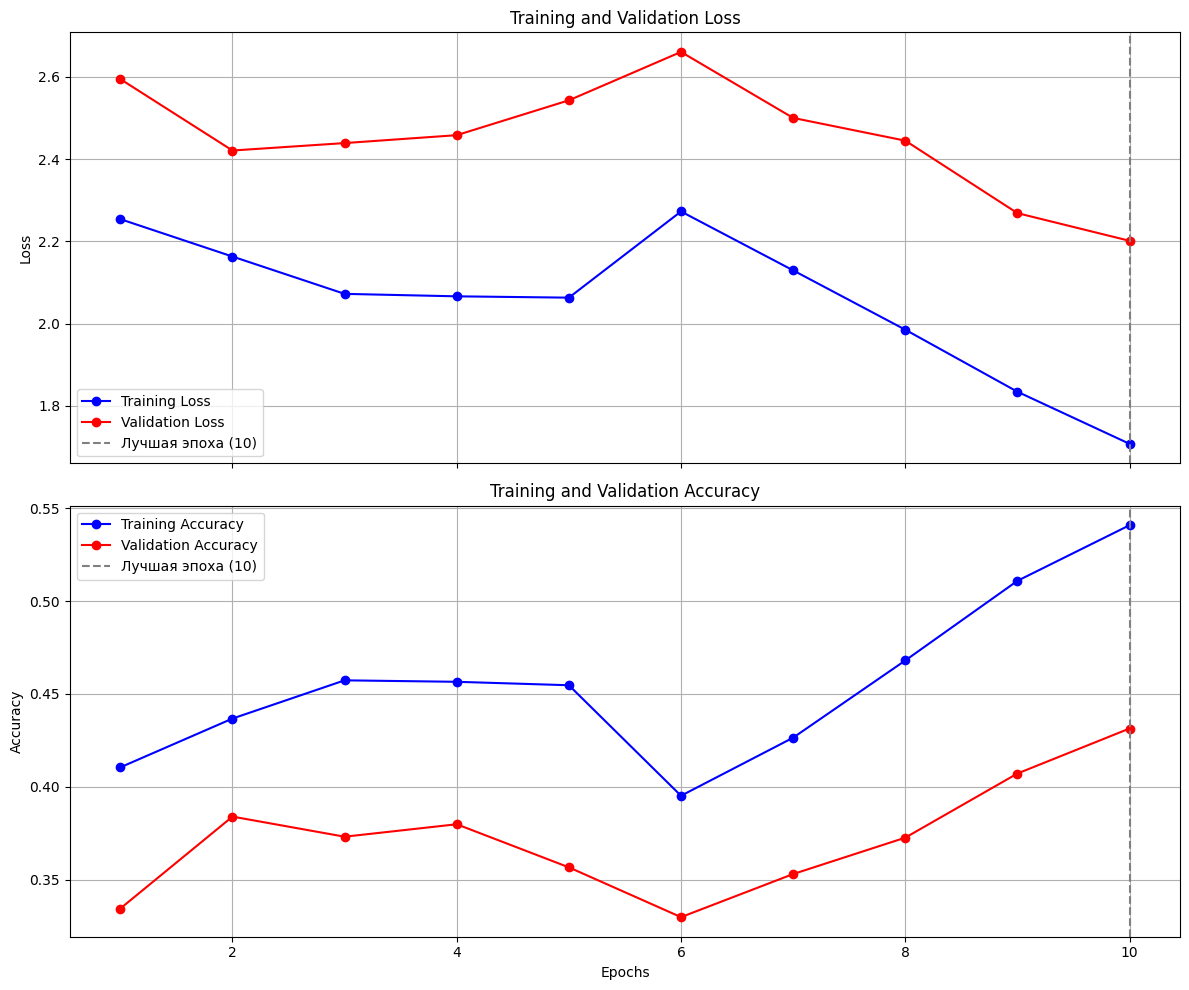

Загрузка весов лучшей модели 10 сохранённой в models/best_model_cnn_upscaled_64_64.pth


In [ ]:
train_dataset_upscaled = Loader(
    split="train",
    root_dir="upscaled_data/64_64/train",
    transform=train_pipeline_base,
)
val_dataset_upscaled = Loader(
    split="val",
    root_dir="upscaled_data/64_64/train",
    transform=val_pipeline,
)
test_dataset_upscaled = Loader(
    split="test",
    root_dir="upscaled_data/64_64/test",
    transform=val_pipeline,
)

train_loader_upscaled = DataLoader(train_dataset_upscaled, batch_size=64, shuffle=True)

val_loader_upscaled = DataLoader(val_dataset_upscaled, batch_size=64, shuffle=False)

test_loader_upscaled = DataLoader(test_dataset_upscaled, batch_size=64, shuffle=False)


model_cnn_upscaled = traning_loop(
    model=simple_model_cnn,
    optimizer_initial=optim.SGD(simple_model_cnn.parameters(), lr=0.01, momentum=0.9),
    optimizer_switch=optim.AdamW(simple_model_cnn.parameters(), lr=0.001),
    optimizer_switch_patience=3,
    train_loader=train_loader_upscaled,
    val_loader=val_loader_upscaled,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=5,
    model_desc="cnn_upscaled_64_64",
    num_epochs=50,
    early_stop_metric="val_acc",
    early_stop_patience=10,
)

# Стало лучше обучаться 

# VAE для генирации новых пикч (правда там пиксельный взрыв в фотографиях)

In [50]:
vae_transform = A.Compose(
    [
        A.Resize(height=32, width=32, interpolation=cv2.INTER_CUBIC),
        A.ToFloat(max_value=255.0),
        ToTensorV2(),
    ]
)

main_task_augment_transform = A.Compose(
    [
        A.Resize(height=32, width=32, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.2),
        A.HorizontalFlip(p=0.2),
        A.RandomRotate90(p=0.2),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 1), lightness=(0.5, 1.5), p=0.6),
        A.Normalize(),
        ToTensorV2(),
    ]
)

In [51]:
class CVAE(nn.Module):
    def __init__(self, channels_img, num_classes, latent_dim, embed_dim, img_size=32):
        super().__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim
        self.num_classes = num_classes
        hidden_dims = [32, 64, 128, 256]
        self.encoder_output_size = img_size // (2 ** len(hidden_dims))
        self.final_conv_channels = hidden_dims[-1]
        self.fc_hidden_input_size = self.final_conv_channels * (
            self.encoder_output_size**2
        )
        self.class_embed = nn.Embedding(num_classes, embed_dim)
        encoder_modules = []
        in_channels = channels_img
        for h_dim in hidden_dims:
            encoder_modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )
            in_channels = h_dim
        self.encoder_conv = nn.Sequential(*encoder_modules)
        self.fc_input_dim = self.fc_hidden_input_size + self.embed_dim
        self.fc_mu = nn.Linear(self.fc_input_dim, latent_dim)
        self.fc_log_var = nn.Linear(self.fc_input_dim, latent_dim)
        self.decoder_input = nn.Linear(
            latent_dim + embed_dim, self.fc_hidden_input_size
        )
        decoder_modules = []
        in_channels = self.final_conv_channels
        temp_hidden_dims = list(reversed(hidden_dims[:-1]))
        for h_dim in temp_hidden_dims:
            decoder_modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels, h_dim, kernel_size=4, stride=2, padding=1
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )
            in_channels = h_dim
        decoder_modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, hidden_dims[0], kernel_size=4, stride=2, padding=1
                ),
                nn.BatchNorm2d(hidden_dims[0]),
                nn.LeakyReLU(0.2, inplace=True),
            )
        )
        self.decoder_conv = nn.Sequential(*decoder_modules)
        self.final_layer = nn.Sequential(
            nn.Conv2d(hidden_dims[0], channels_img, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x, c):
        c_embed = self.class_embed(c)
        result = self.encoder_conv(x)
        result = torch.flatten(result, start_dim=1)
        combined = torch.cat([result, c_embed], dim=1)
        mu = self.fc_mu(combined)
        log_var = self.fc_log_var(combined)
        return mu, log_var

    def decode(self, z, c):
        c_embed = self.class_embed(c)
        z_cond = torch.cat([z, c_embed], dim=1)
        result = self.decoder_input(z_cond)
        result = result.view(
            -1,
            self.final_conv_channels,
            self.encoder_output_size,
            self.encoder_output_size,
        )
        result = self.decoder_conv(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, c)
        return recon_x, mu, log_var

    def generate(self, c, device):
        num_samples = c.size(0)
        z = torch.randn(num_samples, self.latent_dim, device=device)
        samples = self.decode(z, c)
        return samples


def vae_loss_function(recon_x, x, mu, log_var, beta=1.0):
    if recon_x.shape != x.shape:
        recon_x = F.interpolate(
            recon_x, size=x.shape[2:], mode="bilinear", align_corners=False
        )
    recon_loss = F.binary_cross_entropy(
        recon_x.clamp(1e-8, 1 - 1e-8), x.clamp(1e-8, 1 - 1e-8), reduction="sum"
    )
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

In [52]:
generated_data_dir = Path("generated_data_cvae")


cvae_train_dataset = Loader(
    split="train_itog",
    root_dir=data_train,
    transform=vae_transform,
)

cvae_dataloader = DataLoader(
    cvae_train_dataset,
    batch_size=64,
    shuffle=True,
)

model = CVAE(
    channels_img=3, num_classes=100, latent_dim=64, embed_dim=16, img_size=32
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min")

generated_data_dir.mkdir(parents=True, exist_ok=True)
for i in range(100):
    (generated_data_dir / str(i)).mkdir(exist_ok=True)

In [53]:
train_losses, recon_losses, kl_losses = [], [], []

for epoch in range(50):
    model.train()
    epoch_loss, epoch_recon, epoch_kl = 0.0, 0.0, 0.0
    num_samples_processed = 0
    loop = tqdm(cvae_dataloader, leave=True, desc=f"Эпох [{epoch+1}/{50}]")

    for batch_data in loop:
        real_images, labels = batch_data

        real_images = real_images.to(device)
        labels = labels.to(device, non_blocking=True).long()
        current_batch_size = real_images.size(0)

        recon_images, mu, log_var = model(real_images, labels)
        loss, recon_loss, kl_div = vae_loss_function(
            recon_images, real_images, mu, log_var, beta=1.0
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        batch_loss_ps = loss.item() / current_batch_size
        batch_recon_ps = recon_loss.item() / current_batch_size
        batch_kl_ps = kl_div.item() / current_batch_size

        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_div.item()
        num_samples_processed += current_batch_size

        loop.set_postfix(
            Loss_ps=f"{batch_loss_ps:.2f}",
            Recon_ps=f"{batch_recon_ps:.2f}",
            KL_ps=f"{batch_kl_ps:.2f}",
            LR=f"{optimizer.param_groups[0]['lr']:.1e}",
        )

    if num_samples_processed > 0:
        avg_epoch_loss = epoch_loss / num_samples_processed
        avg_recon_loss = epoch_recon / num_samples_processed
        avg_kl_div = epoch_kl / num_samples_processed
        train_losses.append(avg_epoch_loss)
        recon_losses.append(avg_recon_loss)
        kl_losses.append(avg_kl_div)
        print(
            f"Эпоха {epoch+1} Avg Loss/Sample: {avg_epoch_loss:.4f}, Avg Recon/Sample: {avg_recon_loss:.4f}, Avg KL/Sample: {avg_kl_div:.4f}"
        )
        scheduler.step(avg_epoch_loss)

Эпох [1/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 1 Avg Loss/Sample: 1892.8461, Avg Recon/Sample: 1864.8086, Avg KL/Sample: 28.0375


Эпох [2/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 2 Avg Loss/Sample: 1815.3565, Avg Recon/Sample: 1780.8620, Avg KL/Sample: 34.4945


Эпох [3/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 3 Avg Loss/Sample: 1798.8620, Avg Recon/Sample: 1763.8661, Avg KL/Sample: 34.9960


Эпох [4/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 4 Avg Loss/Sample: 1791.1221, Avg Recon/Sample: 1755.4974, Avg KL/Sample: 35.6247


Эпох [5/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 5 Avg Loss/Sample: 1785.5578, Avg Recon/Sample: 1749.4437, Avg KL/Sample: 36.1141


Эпох [6/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 6 Avg Loss/Sample: 1783.2456, Avg Recon/Sample: 1746.6517, Avg KL/Sample: 36.5939


Эпох [7/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 7 Avg Loss/Sample: 1781.3037, Avg Recon/Sample: 1744.3734, Avg KL/Sample: 36.9303


Эпох [8/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 8 Avg Loss/Sample: 1778.8695, Avg Recon/Sample: 1741.6145, Avg KL/Sample: 37.2549


Эпох [9/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 9 Avg Loss/Sample: 1777.0838, Avg Recon/Sample: 1739.4610, Avg KL/Sample: 37.6228


Эпох [10/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 10 Avg Loss/Sample: 1774.7941, Avg Recon/Sample: 1736.6452, Avg KL/Sample: 38.1489


Эпох [11/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 11 Avg Loss/Sample: 1773.2562, Avg Recon/Sample: 1734.7522, Avg KL/Sample: 38.5041


Эпох [12/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 12 Avg Loss/Sample: 1771.3664, Avg Recon/Sample: 1732.3492, Avg KL/Sample: 39.0172


Эпох [13/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 13 Avg Loss/Sample: 1771.4228, Avg Recon/Sample: 1732.0903, Avg KL/Sample: 39.3326


Эпох [14/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 14 Avg Loss/Sample: 1769.5661, Avg Recon/Sample: 1729.9027, Avg KL/Sample: 39.6634


Эпох [15/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 15 Avg Loss/Sample: 1769.0484, Avg Recon/Sample: 1729.2113, Avg KL/Sample: 39.8371


Эпох [16/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 16 Avg Loss/Sample: 1768.5559, Avg Recon/Sample: 1728.5584, Avg KL/Sample: 39.9975


Эпох [17/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 17 Avg Loss/Sample: 1766.8401, Avg Recon/Sample: 1726.6394, Avg KL/Sample: 40.2007


Эпох [18/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 18 Avg Loss/Sample: 1767.2269, Avg Recon/Sample: 1726.8488, Avg KL/Sample: 40.3781


Эпох [19/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 19 Avg Loss/Sample: 1766.4959, Avg Recon/Sample: 1726.0930, Avg KL/Sample: 40.4029


Эпох [20/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 20 Avg Loss/Sample: 1765.6414, Avg Recon/Sample: 1724.9808, Avg KL/Sample: 40.6606


Эпох [21/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 21 Avg Loss/Sample: 1765.4049, Avg Recon/Sample: 1724.7851, Avg KL/Sample: 40.6198


Эпох [22/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 22 Avg Loss/Sample: 1764.5799, Avg Recon/Sample: 1723.8261, Avg KL/Sample: 40.7537


Эпох [23/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 23 Avg Loss/Sample: 1763.8098, Avg Recon/Sample: 1722.9037, Avg KL/Sample: 40.9061


Эпох [24/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 24 Avg Loss/Sample: 1764.1680, Avg Recon/Sample: 1723.2998, Avg KL/Sample: 40.8682


Эпох [25/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 25 Avg Loss/Sample: 1763.0868, Avg Recon/Sample: 1721.9806, Avg KL/Sample: 41.1062


Эпох [26/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 26 Avg Loss/Sample: 1763.2702, Avg Recon/Sample: 1722.1447, Avg KL/Sample: 41.1255


Эпох [27/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 27 Avg Loss/Sample: 1762.5634, Avg Recon/Sample: 1721.3624, Avg KL/Sample: 41.2010


Эпох [28/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 28 Avg Loss/Sample: 1761.5531, Avg Recon/Sample: 1720.4263, Avg KL/Sample: 41.1268


Эпох [29/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 29 Avg Loss/Sample: 1762.1654, Avg Recon/Sample: 1720.8733, Avg KL/Sample: 41.2921


Эпох [30/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 30 Avg Loss/Sample: 1761.2291, Avg Recon/Sample: 1719.8089, Avg KL/Sample: 41.4202


Эпох [31/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 31 Avg Loss/Sample: 1761.0030, Avg Recon/Sample: 1719.5260, Avg KL/Sample: 41.4770


Эпох [32/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 32 Avg Loss/Sample: 1761.2249, Avg Recon/Sample: 1719.7146, Avg KL/Sample: 41.5103


Эпох [33/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 33 Avg Loss/Sample: 1760.6779, Avg Recon/Sample: 1719.2014, Avg KL/Sample: 41.4765


Эпох [34/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 34 Avg Loss/Sample: 1760.4096, Avg Recon/Sample: 1718.8387, Avg KL/Sample: 41.5709


Эпох [35/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 35 Avg Loss/Sample: 1760.0626, Avg Recon/Sample: 1718.3888, Avg KL/Sample: 41.6738


Эпох [36/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 36 Avg Loss/Sample: 1760.0356, Avg Recon/Sample: 1718.4113, Avg KL/Sample: 41.6244


Эпох [37/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 37 Avg Loss/Sample: 1759.5790, Avg Recon/Sample: 1717.7776, Avg KL/Sample: 41.8014


Эпох [38/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 38 Avg Loss/Sample: 1759.0350, Avg Recon/Sample: 1717.2276, Avg KL/Sample: 41.8074


Эпох [39/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 39 Avg Loss/Sample: 1758.9605, Avg Recon/Sample: 1717.1156, Avg KL/Sample: 41.8449


Эпох [40/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 40 Avg Loss/Sample: 1758.4258, Avg Recon/Sample: 1716.6165, Avg KL/Sample: 41.8093


Эпох [41/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 41 Avg Loss/Sample: 1758.5373, Avg Recon/Sample: 1716.7608, Avg KL/Sample: 41.7765


Эпох [42/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 42 Avg Loss/Sample: 1758.6758, Avg Recon/Sample: 1716.6720, Avg KL/Sample: 42.0038


Эпох [43/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 43 Avg Loss/Sample: 1757.9102, Avg Recon/Sample: 1716.1357, Avg KL/Sample: 41.7745


Эпох [44/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 44 Avg Loss/Sample: 1758.0567, Avg Recon/Sample: 1716.1278, Avg KL/Sample: 41.9289


Эпох [45/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 45 Avg Loss/Sample: 1757.4202, Avg Recon/Sample: 1715.4222, Avg KL/Sample: 41.9980


Эпох [46/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 46 Avg Loss/Sample: 1757.1553, Avg Recon/Sample: 1715.2118, Avg KL/Sample: 41.9435


Эпох [47/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 47 Avg Loss/Sample: 1757.7938, Avg Recon/Sample: 1715.6643, Avg KL/Sample: 42.1295


Эпох [48/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 48 Avg Loss/Sample: 1757.0430, Avg Recon/Sample: 1715.0485, Avg KL/Sample: 41.9945


Эпох [49/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 49 Avg Loss/Sample: 1757.2325, Avg Recon/Sample: 1715.1392, Avg KL/Sample: 42.0933


Эпох [50/50]:   0%|          | 0/149 [00:00<?, ?it/s]

Эпоха 50 Avg Loss/Sample: 1757.1634, Avg Recon/Sample: 1715.0825, Avg KL/Sample: 42.0809


In [54]:
model.eval()
num_to_generate_per_class = 50

with torch.no_grad():
    for class_idx in tqdm(range(100), desc="Генерация изображений"):
        class_dir = generated_data_dir / str(class_idx)
        num_generated_for_class = 0
        while num_generated_for_class < num_to_generate_per_class:
            needed = num_to_generate_per_class - num_generated_for_class
            current_batch_size = min(128, needed)
            if current_batch_size <= 0:
                break
            current_labels = torch.full(
                (current_batch_size,), class_idx, dtype=torch.long, device=device
            )
            generated_batch = model.generate(current_labels, device).cpu()
            for i in range(generated_batch.size(0)):
                if num_generated_for_class < num_to_generate_per_class:
                    save_path = (
                        class_dir / f"generated_{num_generated_for_class:04d}.png"
                    )
                    img_tensor = generated_batch[i]
                    if img_tensor.ndim == 4 and img_tensor.shape[0] == 1:
                        img_tensor = img_tensor.squeeze(0)
                    save_image(img_tensor, save_path, normalize=False)
                    num_generated_for_class += 1

Генерация изображений:   0%|          | 0/100 [00:00<?, ?it/s]

In [55]:
original_train_dataset_main = Loader(
    split="train",
    root_dir=data_train,
    transform=main_task_augment_transform,
)

original_val_dataset_main = Loader(
    split="val",
    root_dir=data_train,
    transform=main_task_augment_transform,
)

generated_train_dataset = Loader(
    split="train_itog",
    root_dir=generated_data_dir,
    transform=main_task_augment_transform,
)


datasets_to_concat = []
if original_train_dataset_main and len(original_train_dataset_main) > 0:
    datasets_to_concat.append(original_train_dataset_main)
else:
    Warning("что-то не то пошло с оригнальным датасетом")

if generated_train_dataset and len(generated_train_dataset) > 0:
    datasets_to_concat.append(generated_train_dataset)
else:
    Warning("что-то не то пошло с генерированным датасетом")

combined_dataset = ConcatDataset(datasets_to_concat)

augmented_train_loader = DataLoader(
    combined_dataset,
    batch_size=64,
    shuffle=True,
)

augmented_val_loader = DataLoader(
    original_val_dataset_main,
    batch_size=64,
    shuffle=False,
)

Обучение модели (cnn_upscaled_64_64):   0%|          | 0/10 [00:00<?, ?it/s]

Эпохи 1/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 1/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 1.00e-06 | Loss(Tr/Val): 3.304/2.769 | Acc(Tr/Val): 0.241/0.310 | (Лучшая метрика: 0.3101 @ Ep 1) | сохранение модели...


Эпохи 2/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 2/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 2/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 2.00e-03 | Loss(Tr/Val): 3.228/2.603 | Acc(Tr/Val): 0.257/0.364 | (Лучшая метрика: 0.3638 @ Ep 2) | сохранение модели...


Эпохи 3/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 3/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 3/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 4.00e-03 | Loss(Tr/Val): 3.210/2.655 | Acc(Tr/Val): 0.257/0.336 | Нет улучшений 1 эпох.(Best: 0.3638)[Optimizer подсчет: 1/3][Early stopping посчет: 1/10]


Эпохи 4/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 4/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 4/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 6.00e-03 | Loss(Tr/Val): 3.227/2.608 | Acc(Tr/Val): 0.252/0.349 | Нет улучшений 2 эпох.(Best: 0.3638)[Optimizer подсчет: 2/3][Early stopping посчет: 2/10]


Эпохи 5/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 5/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 5/10 | Оптимайзер: SGD | Loss: CrossEntropyLoss | Learning Rate: 8.00e-03 | Loss(Tr/Val): 3.222/2.669 | Acc(Tr/Val): 0.248/0.348 | Нет улучшений 3 эпох.(Best: 0.3638)[Optimizer подсчет: 3/3][Early stopping посчет: 3/10]
Переключение оптимайзер AdamW (Текущщий LR: 1.00e-03).
Шедулер пересоздан: CosineAnnealingLR


Эпохи 6/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 6/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 6/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-03 | Loss(Tr/Val): 3.394/2.788 | Acc(Tr/Val): 0.220/0.324 | Нет улучшений 1 эпох.(Best: 0.3638)[Optimizer подсчет: 4/3][Early stopping посчет: 1/10]


Эпохи 7/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 7/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 7/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.05e-04 | Loss(Tr/Val): 3.283/2.862 | Acc(Tr/Val): 0.232/0.299 | Нет улучшений 2 эпох.(Best: 0.3638)[Optimizer подсчет: 5/3][Early stopping посчет: 2/10]


Эпохи 8/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 8/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 8/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 6.55e-04 | Loss(Tr/Val): 3.165/2.683 | Acc(Tr/Val): 0.255/0.334 | Нет улучшений 3 эпох.(Best: 0.3638)[Optimizer подсчет: 6/3][Early stopping посчет: 3/10]


Эпохи 9/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 9/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 9/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 3.46e-04 | Loss(Tr/Val): 3.038/2.515 | Acc(Tr/Val): 0.285/0.376 | (Лучшая метрика: 0.3762 @ Ep 9) | сохранение модели...


Эпохи 10/10 обучения:   0%|          | 0/197 [00:00<?, ?it/s]

Эпохи 10/10 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 10/10 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 9.64e-05 | Loss(Tr/Val): 2.949/2.501 | Acc(Tr/Val): 0.300/0.380 | (Лучшая метрика: 0.3803 @ Ep 10) | сохранение модели...


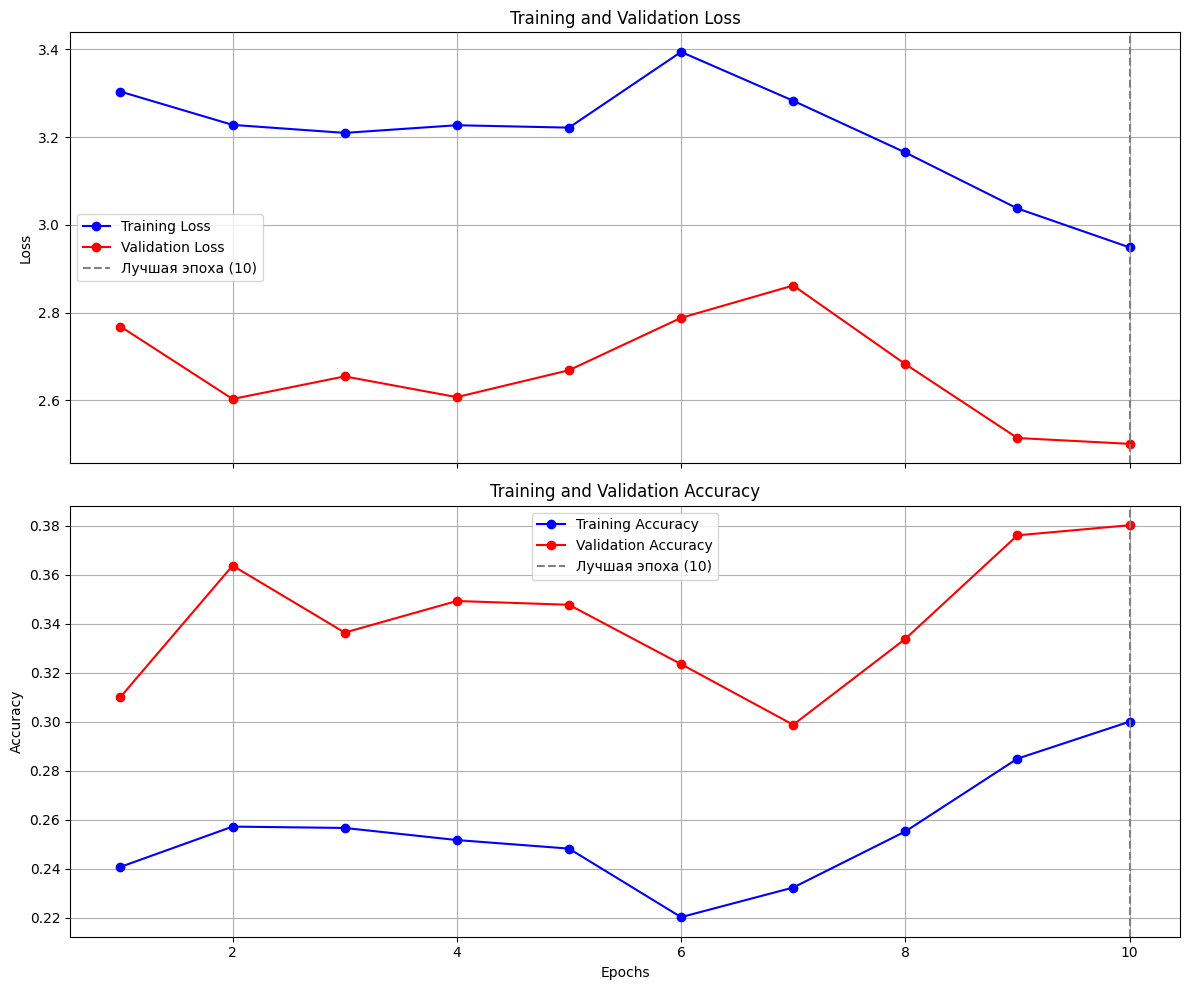

Загрузка весов лучшей модели 10 сохранённой в models/best_model_cnn_upscaled_64_64.pth


In [57]:
model_cnn_generate = traning_loop(
    model=simple_model_cnn,
    optimizer_initial=optim.SGD(simple_model_cnn.parameters(), lr=0.01, momentum=0.9),
    optimizer_switch=optim.AdamW(simple_model_cnn.parameters(), lr=0.001),
    optimizer_switch_patience=3,
    train_loader=augmented_train_loader,
    val_loader=augmented_val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=5,
    model_desc="cnn_upscaled_64_64",
    num_epochs=10,
    early_stop_metric="val_acc",
    early_stop_patience=10,
)

# Чуть лучше чем на обычных фотографиях

# Pipeline топ модели

In [1]:
import os
import random
import glob
from pathlib import Path
from network_swinir import SwinIR

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR, LinearLR, SequentialLR
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm
from torchvision.utils import save_image

/opt/anaconda3/envs/dl/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
data_train = "data/train"
data_test = "data/test"
seed = 42

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Используется:", device)


### воспроизводимость
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(seed=seed)

Используется: mps


In [3]:
### класс лоадер

train_transform = A.Compose(
    [
        A.Resize(height=224, width=224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.2),
        A.RandomGridShuffle(p=0.3),
        A.HorizontalFlip(p=0.2),
        A.RandomRotate90(p=0.2),
        A.PixelDropout(p=0.5),
        A.Sharpen(alpha=(0.1, 1), lightness=(0.5, 1.5), p=0.7),
        A.Normalize(),
        ToTensorV2(),
    ]
)


val_transform = A.Compose(
    [
        A.Resize(224, 224, p=1.0, interpolation=cv2.INTER_CUBIC),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]
)


class Loader(Dataset):
    def __init__(
        self,
        split="train",
        root_dir="data/train",
        transform=None,
    ):
        self.split = split
        self.transform = transform
        self.samples = []

        if split == "test":
            root_dir = "data/test"
            image_files = glob.glob(os.path.join(root_dir, "*.jpg")) + glob.glob(
                os.path.join(root_dir, "*.png")
            )

            def extract_number(path):
                name = os.path.splitext(os.path.basename(path))[0]
                try:
                    return int(name)
                except ValueError:
                    return float("inf")

            image_files = sorted(image_files, key=extract_number)

            for file_path in image_files:
                self.samples.append((file_path, 0))
        else:

            def split_files(files, split_type):
                n = len(files)
                sorted_files = sorted(files)
                if split_type == "train":
                    return sorted_files[: int(0.8 * n)]
                elif split_type == "val":
                    return sorted_files[int(0.8 * n) :]
                elif split_type == "train_itog":
                    return sorted_files
                return []

            for class_folder in sorted(os.listdir(root_dir)):
                class_path = os.path.join(root_dir, class_folder)
                if os.path.isdir(class_path):
                    try:
                        class_idx = int(class_folder)
                    except ValueError:
                        continue

                    image_files = glob.glob(os.path.join(class_path, "*"))
                    split_files_list = split_files(image_files, split)
                    for file_path in split_files_list:
                        self.samples.append((file_path, class_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)

        if image is None:
            next_idx = (idx + 1) % len(self.samples)
            return self.__getitem__(next_idx)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            current_transform = self.transform

            augmented = current_transform(image=image)
            image = augmented["image"]

        return image, label


train_dataset = Loader(
    split="train",
    root_dir=data_train,
    transform=train_transform,
)
val_dataset = Loader(
    split="val",
    root_dir=data_train,
    transform=val_transform,
)

test_dataset = Loader(split="test", root_dir=data_test, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


my_submit = pd.read_csv("sample_submission.csv")
my_submit.head()


def predict_on_test(model, test_loader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_loader:
            if isinstance(images, (list, tuple)):
                images = images[0]

            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions


def train_one_epoch(model, criterion, optimizer, dataloader, device, epoch, num_epochs):
    model.train()

    running_loss = torch.tensor(0.0, device=device)
    correct_predictions = 0
    total_samples = 0

    batch_iterator = tqdm(
        dataloader, desc=f"Эпохи {epoch+1}/{num_epochs} обучения", leave=False
    )

    for inputs, labels in batch_iterator:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = outputs.contiguous()
        loss = criterion(outputs, labels)

        running_loss += loss.detach() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

        current_acc = (
            (predicted == labels).sum().item() / labels.size(0)
            if labels.size(0) > 0
            else 0
        )
        batch_iterator.set_postfix(loss=f"{loss.item():.4f}", acc=f"{current_acc:.4f}")

    if total_samples > 0:
        epoch_loss = (running_loss / total_samples).item()
        epoch_accuracy = correct_predictions / total_samples
    else:
        epoch_loss = np.inf
        epoch_accuracy = 0

    return epoch_loss, epoch_accuracy


def validate(model, criterion, dataloader, device, epoch, num_epochs):
    model.eval()
    running_loss = torch.tensor(0.0, device=device)
    correct_predictions = 0
    total_samples = 0

    batch_iterator = tqdm(
        dataloader, desc=f"Эпохи {epoch+1}/{num_epochs} валидации", leave=False
    )

    with torch.no_grad():
        for inputs, labels in batch_iterator:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            outputs = outputs.contiguous()
            loss = criterion(outputs, labels)

            running_loss += loss.detach() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            current_acc = (predicted == labels).sum().item() / labels.size(0)
            batch_iterator.set_postfix(
                loss=f"{loss.item():.4f}", acc=f"{current_acc:.4f}"
            )

    if total_samples > 0:
        epoch_loss = (running_loss / total_samples).item()
        epoch_accuracy = correct_predictions / total_samples
    else:
        epoch_loss = np.inf
        epoch_accuracy = 0

    return epoch_loss, epoch_accuracy


def traning_loop(
    model,
    num_epochs,
    optimizer_initial,
    train_loader,
    val_loader,
    device,
    optimizer_switch=None,
    optimizer_switch_patience=None,
    criterion_initial=nn.CrossEntropyLoss(),
    criterion_switch=None,
    criterion_switch_patience=None,
    warmup_epochs=0,
    lr_scheduler_type="cosine",
    early_stop_patience=10,
    early_stop_metric="val_loss",
    best_model_path="models/best_model.pth",
    model_desc=None,
):

    if model_desc:
        os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
        base, ext = os.path.splitext(best_model_path)
        final_best_model_path = f"{base}_{model_desc}{ext}"
    else:
        final_best_model_path = best_model_path
        os.makedirs(os.path.dirname(final_best_model_path), exist_ok=True)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "lr": [],
    }
    best_metric_value = (
        float("inf") if early_stop_metric == "val_loss" else float("-inf")
    )

    es_epochs_no_improve = 0
    ls_epochs_no_improve = 0
    os_epochs_no_improve = 0

    best_epoch = -1
    scheduler = None
    switched_loss = False
    switched_optimizer = False
    dynamic_loss_switch_enabled = (
        criterion_switch is not None
        and criterion_switch_patience is not None
        and criterion_switch_patience > 0
    )
    dynamic_optimizer_switch_enabled = (
        optimizer_switch is not None
        and optimizer_switch_patience is not None
        and optimizer_switch_patience > 0
    )

    current_criterion = criterion_initial
    current_optimizer = optimizer_initial

    scheduler_warmup = None
    scheduler_main = None
    if warmup_epochs > 0 and warmup_epochs < num_epochs:
        scheduler_warmup = LinearLR(
            current_optimizer,
            start_factor=1e-4,
            end_factor=1.0,
            total_iters=warmup_epochs,
        )
        main_scheduler_start_epoch = warmup_epochs
    else:
        main_scheduler_start_epoch = 0

    main_scheduler_epochs = num_epochs - main_scheduler_start_epoch

    if main_scheduler_epochs > 0:
        if lr_scheduler_type == "cosine":
            scheduler_main = CosineAnnealingLR(
                current_optimizer, T_max=main_scheduler_epochs, eta_min=1e-6
            )
        elif lr_scheduler_type == "step":
            step_size = 10
            gamma = 0.1
            scheduler_main = StepLR(current_optimizer, step_size=step_size, gamma=gamma)

    if scheduler_warmup and scheduler_main:
        scheduler = SequentialLR(
            current_optimizer,
            schedulers=[scheduler_warmup, scheduler_main],
            milestones=[warmup_epochs],
        )
    elif scheduler_main:
        scheduler = scheduler_main
    elif scheduler_warmup:
        scheduler = scheduler_warmup

    outer_tqdm = tqdm(
        range(num_epochs),
        desc=f"Обучение модели ({model_desc if model_desc else 'NoDesc'})",
    )
    for epoch in outer_tqdm:

        train_loss, train_acc = train_one_epoch(
            model=model,
            criterion=current_criterion,
            optimizer=current_optimizer,
            dataloader=train_loader,
            device=device,
            epoch=epoch,
            num_epochs=num_epochs,
        )
        val_loss, val_acc = validate(
            model=model,
            criterion=current_criterion,
            dataloader=val_loader,
            device=device,
            epoch=epoch,
            num_epochs=num_epochs,
        )

        current_lr = current_optimizer.param_groups[0]["lr"]
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

        log_message = (
            f"Эпоха {epoch+1}/{num_epochs} | "
            f"Оптимайзер: {type(current_optimizer).__name__} | Loss: {type(current_criterion).__name__} | "
            f"Learning Rate: {current_lr:.2e} | Loss(Tr/Val): {train_loss:.3f}/{val_loss:.3f} | "
            f"Acc(Tr/Val): {train_acc:.3f}/{val_acc:.3f} | "
        )

        current_metric = val_loss if early_stop_metric == "val_loss" else val_acc
        is_better = (
            early_stop_metric == "val_loss" and current_metric < best_metric_value
        ) or (early_stop_metric == "val_acc" and current_metric > best_metric_value)

        if is_better:
            best_metric_value = current_metric
            log_message += f"(Лучшая метрика: {best_metric_value:.4f} @ Ep {epoch + 1}) | сохранение модели..."
            outer_tqdm.write(log_message)
            torch.save(model.state_dict(), final_best_model_path)
            es_epochs_no_improve = 0
            ls_epochs_no_improve = 0
            os_epochs_no_improve = 0
            best_epoch = epoch + 1
        else:
            es_epochs_no_improve += 1
            ls_epochs_no_improve += 1
            os_epochs_no_improve += 1
            stagnation_msg = f"Нет улучшений {es_epochs_no_improve} эпох."
            stagnation_msg += f"(Best: {best_metric_value:.4f})"
            if dynamic_loss_switch_enabled:
                stagnation_msg += f"[Loss swich подсчет: {ls_epochs_no_improve}/{criterion_switch_patience}]"
            if dynamic_optimizer_switch_enabled:
                stagnation_msg += f"[Optimizer подсчет: {os_epochs_no_improve}/{optimizer_switch_patience}]"
            stagnation_msg += (
                f"[Early stopping посчет: {es_epochs_no_improve}/{early_stop_patience}]"
            )
            outer_tqdm.write(log_message + stagnation_msg)

        if (
            dynamic_loss_switch_enabled
            and ls_epochs_no_improve >= criterion_switch_patience
            and not switched_loss
        ):
            current_criterion = criterion_switch
            switched_loss = True
            os_epochs_no_improve = 0
            outer_tqdm.write(
                f"Переключение Loss на {type(current_criterion).__name__}. Сброс стагнации для Early Stopping."
            )

        if (
            dynamic_optimizer_switch_enabled
            and os_epochs_no_improve >= optimizer_switch_patience
            and not switched_optimizer
        ):
            current_optimizer = optimizer_switch
            switched_optimizer = True
            new_optimizer_lr = current_optimizer.param_groups[0]["lr"]
            outer_tqdm.write(
                f"Переключение оптимайзер {type(current_optimizer).__name__} (Текущщий LR: {new_optimizer_lr:.2e})."
            )

            scheduler = None
            scheduler_main = None
            recreate_current_epoch = epoch + 1
            recreate_main_scheduler_start_epoch = recreate_current_epoch
            recreate_main_scheduler_epochs = max(
                0, num_epochs - recreate_main_scheduler_start_epoch
            )

            if recreate_main_scheduler_epochs > 0:
                if lr_scheduler_type == "cosine":
                    scheduler_main = CosineAnnealingLR(
                        current_optimizer,
                        T_max=recreate_main_scheduler_epochs,
                        eta_min=1e-6,
                    )
                elif lr_scheduler_type == "step":
                    step_size = 10
                    gamma = 0.1
                    scheduler_main = StepLR(
                        current_optimizer, step_size=step_size, gamma=gamma
                    )
            else:
                outer_tqdm.write(f"Не осталось эпох для создания нового шедулера.")

            scheduler = scheduler_main
            outer_tqdm.write(
                f"Шедулер пересоздан: {type(scheduler).__name__ if scheduler else 'None'}"
            )
            es_epochs_no_improve = 0

        if scheduler and not (
            switched_optimizer and os_epochs_no_improve == optimizer_switch_patience
        ):
            scheduler.step()

        if es_epochs_no_improve >= early_stop_patience:
            outer_tqdm.write(
                f"\nEarly stopping тригернулся после эпохи {epoch + 1}. Нет улучшений в '{early_stop_metric}' для {early_stop_patience} эпох."
            )
            outer_tqdm.write(
                f"Лучшая эпоха: {best_epoch}, лучшая метрика {early_stop_metric}: {best_metric_value:.4f}"
            )
            break

    num_epochs_completed = len(history["train_loss"])
    epochs_range = range(1, num_epochs_completed + 1)

    if num_epochs_completed > 0:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

        ax1.plot(epochs_range, history["train_loss"], "bo-", label="Training Loss")
        ax1.plot(epochs_range, history["val_loss"], "ro-", label="Validation Loss")
        ax1.set_title("Training and Validation Loss")
        ax1.set_ylabel("Loss")
        ax1.legend()
        ax1.grid(True)

        ax2.plot(epochs_range, history["train_acc"], "bo-", label="Training Accuracy")
        ax2.plot(epochs_range, history["val_acc"], "ro-", label="Validation Accuracy")
        ax2.set_title("Training and Validation Accuracy")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Accuracy")
        ax2.legend()
        ax2.grid(True)

        if best_epoch != -1:
            ax1.axvline(
                x=best_epoch,
                color="grey",
                linestyle="--",
                label=f"Лучшая эпоха ({best_epoch})",
            )
            ax2.axvline(
                x=best_epoch,
                color="grey",
                linestyle="--",
                label=f"Лучшая эпоха ({best_epoch})",
            )
            ax1.legend()
            ax2.legend()

        plt.tight_layout()
        plt.show()

    if best_epoch != -1 and os.path.exists(final_best_model_path):
        print(
            f"Загрузка весов лучшей модели {best_epoch} сохранённой в {final_best_model_path}"
        )
        model.load_state_dict(
            torch.load(final_best_model_path, map_location=device, weights_only=True)
        )
    else:
        print(
            f"Нет улучшений в модели или нет файла в  {final_best_model_path}. Возвращаемся к модели к последней эпохе ({num_epochs_completed})."
        )

    return model

Обучение модели (Densenet161_head):   0%|          | 0/1 [00:00<?, ?it/s]

Эпохи 1/1 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/1 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/1 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-03 | Loss(Tr/Val): 4.348/3.455 | Acc(Tr/Val): 0.043/0.159 | (Лучшая метрика: 0.1594 @ Ep 1) | сохранение модели...


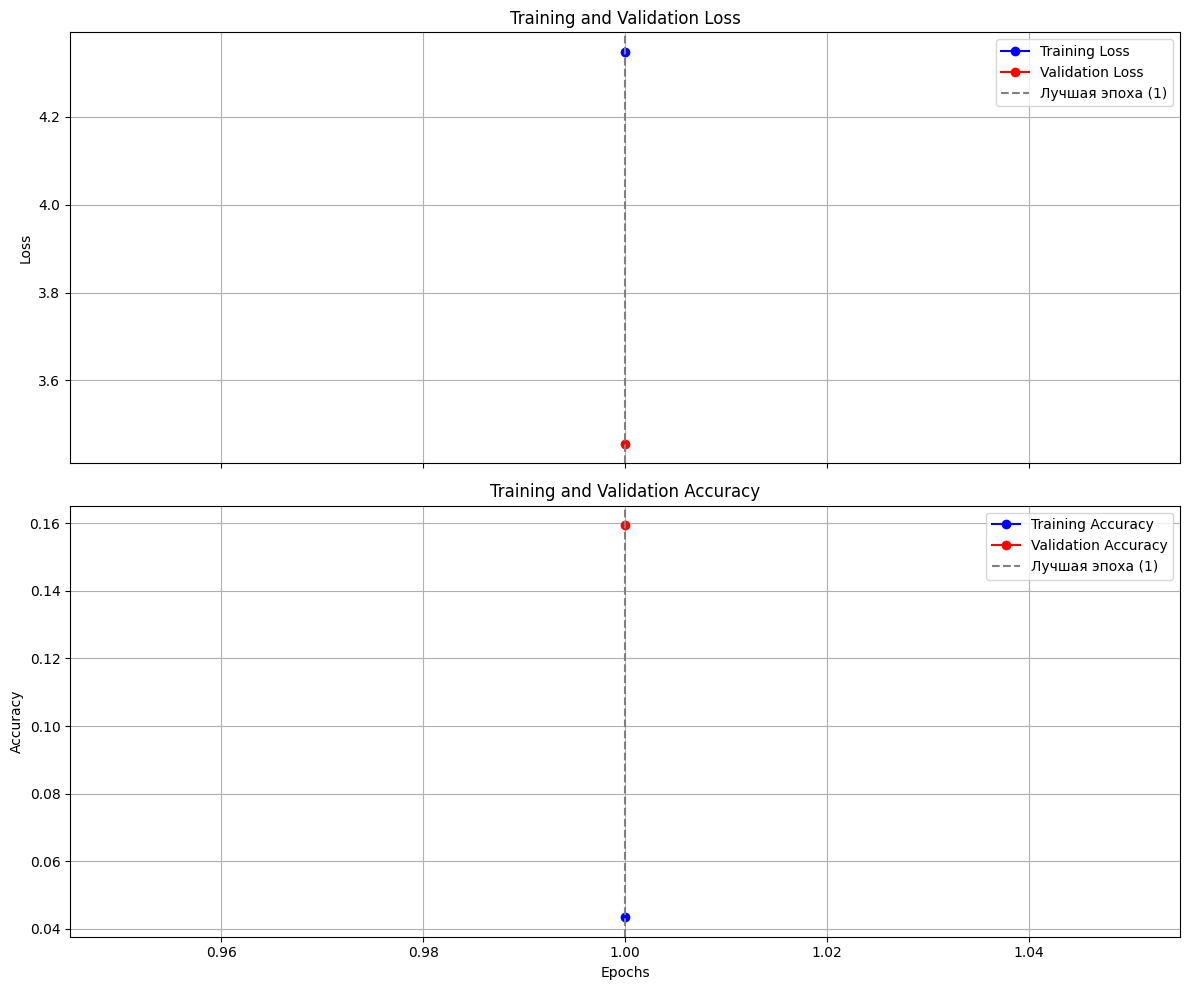

Загрузка весов лучшей модели 1 сохранённой в models/best_model_Densenet161_head.pth


In [ ]:
model_Densenet161 = torchvision.models.densenet161(
    weights=torchvision.models.DenseNet161_Weights.DEFAULT
)

for param in model_Densenet161.parameters():
    param.requires_grad = False

num_features = model_Densenet161.classifier.in_features
num_classes = 100

head = nn.Sequential(
    nn.Linear(num_features, 1104),
    nn.ReLU(),
    nn.Linear(1104, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),
)

model_Densenet161.classifier = head

model_Densenet161.to(device)

model_Densenet161 = traning_loop(
    model=model_Densenet161,
    optimizer_initial=optim.AdamW(
        model_Densenet161.parameters(), lr=0.001, weight_decay=1e-4
    ),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=5,
    model_desc="Densenet161_head",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=5,
    lr_scheduler_type="cosine",
)

Обучение модели (Densenet161_fine-tuning):   0%|          | 0/1 [00:00<?, ?it/s]

Эпохи 1/1 обучения:   0%|          | 0/119 [00:00<?, ?it/s]

Эпохи 1/1 валидации:   0%|          | 0/31 [00:00<?, ?it/s]

Эпоха 1/1 | Оптимайзер: AdamW | Loss: CrossEntropyLoss | Learning Rate: 1.00e-04 | Loss(Tr/Val): 3.250/2.427 | Acc(Tr/Val): 0.181/0.397 | (Лучшая метрика: 0.3968 @ Ep 1) | сохранение модели...


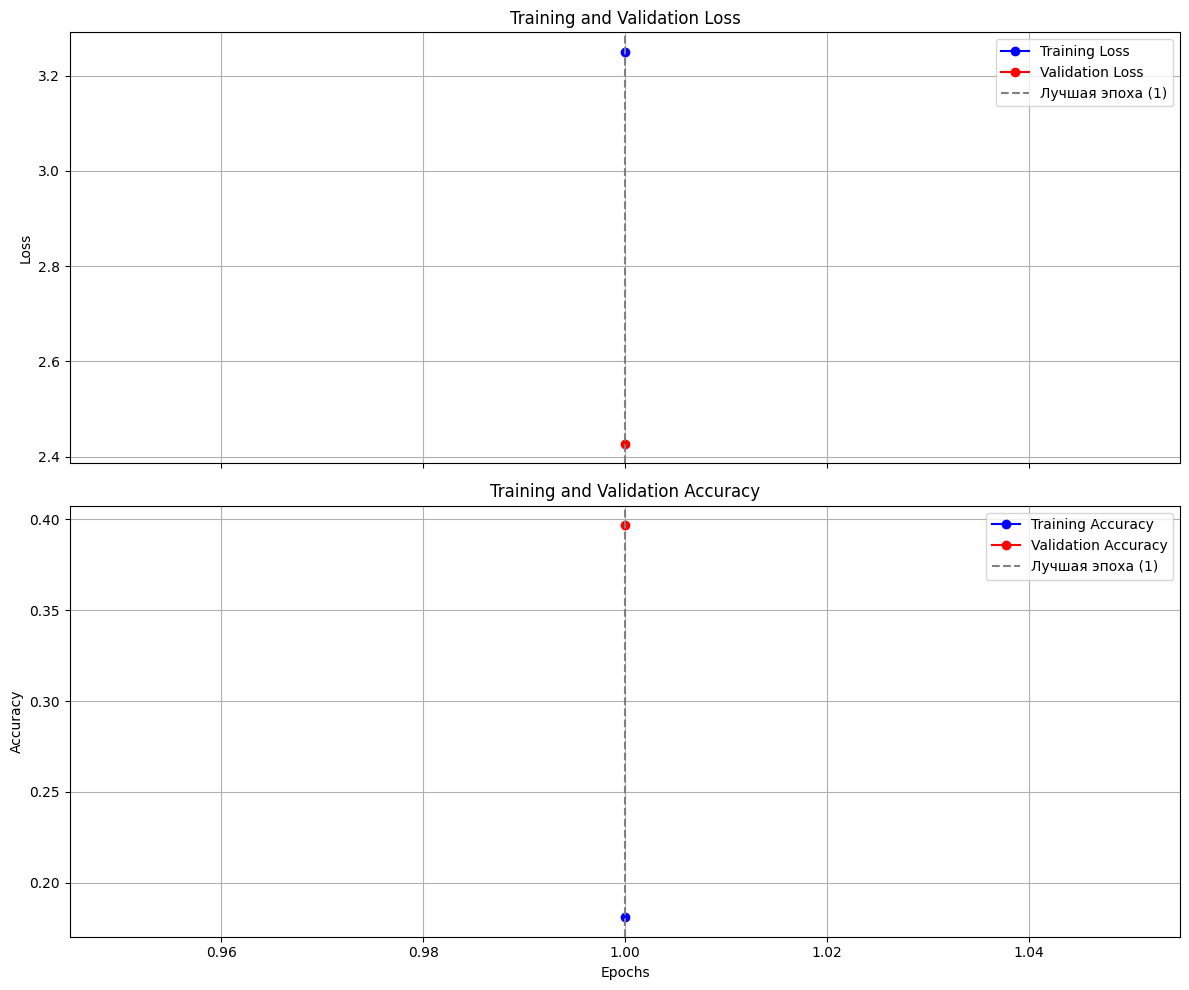

Загрузка весов лучшей модели 1 сохранённой в models/best_model_Densenet161_fine-tuning.pth


In [ ]:
for param in model_Densenet161.parameters():
    param.requires_grad = True

optimizer_ft = torch.optim.AdamW(
    model_Densenet161.parameters(), lr=0.0001, weight_decay=1e-4
)


model_Densenet161 = traning_loop(
    model=model_Densenet161,
    optimizer_initial=optimizer_ft,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    criterion_initial=nn.CrossEntropyLoss(),
    warmup_epochs=3,
    model_desc="Densenet161_fine-tuning",
    num_epochs=20,
    early_stop_metric="val_acc",
    early_stop_patience=3,
)

In [6]:
my_submit["target"] = predict_on_test(model_Densenet161, test_loader, device)
my_submit.to_csv("densenet161_fine-tuning_xuz.csv", index=False)